$$
{\huge \textbf{Dark-Fiber Charakterisierung}}\\
$$

$$
{\huge \textbf{für entanglement polarisierter QKD}}\\ 
$$

$$
{\normalsize \textbf{Aufbereitung und Analyse der Messdaten nach Tageszyklen}}
$$

**Autor:** Laura Komma  
**Datensatz:** Nordhausen - Sundhausen

# Aufbereitung der Messdaten
## Ressourcen und Literatur
- [Messdaten](https://zenodo.org/uploads/15183223)
- [Messgerät](https://www.thorlabs.com/_sd.cfm?fileName=MTN007790-D02.pdf&partNumber=PAX1000IR2/M)
- [Plotting-Tool "py_pol"](https://py-pol.readthedocs.io/en/master/index.html)

## Verwendete Libraries / Softwaretools

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import numpy as np
import io
import datetime
from IPython.display import Image

from scipy.stats import norm
from scipy.signal import butter, filtfilt

from py_pol.jones_vector import Jones_vector, degrees
from py_pol.stokes import Stokes

## Eigene Hilfsfunktionen

In [2]:
def format_time(x, pos):
    h = int(x) // 3600
    m = (int(x) % 3600) // 60
    return f"{h:02d}:{m:02d}"

In [3]:
def lowpass(data, box = 100):
    box = box
    LP_filter = np.full(int(box), 1/box) 
    lps = np.convolve(ydata, LP_filter)
    lps = lps[ int((box-1) / 2) :len(lps) - int((box - 1) / 2)]
    return lps

def highpass(data, box = 100):
    lps = lowpass(data, box)
    hps = data - lps[:-1]
    return hps

In [4]:
def butter_filter(data, cutoff, fs=18, order=4, btype='low'):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    y = filtfilt(b, a, data)
    return y

In [5]:
def convert_angel(az, el):
    az = np.array(az) * degrees
    el = np.array(el) * degrees
    
    x = np.cos(2*el) * np.cos(2*az)
    y = np.cos(2*el) * np.sin(2*az)
    z = np.sin(2*el)
    return x, y, z

In [6]:
def calculate_freq(x, y, z):
    bins = 50
    coords = np.vstack((x, y, z)).T
    hist, edges = np.histogramdd(coords, bins=bins)

    # Indices for each coordinate pair (with clipping)
    bin_indices = [
        np.clip(np.digitize(x, edges[0]) - 1, 0, bins - 1),
        np.clip(np.digitize(y, edges[1]) - 1, 0, bins - 1),
        np.clip(np.digitize(z, edges[2]) - 1, 0, bins - 1)
    ]
    freq = hist[bin_indices[0], bin_indices[1], bin_indices[2]]
    
    return freq

In [7]:
def plot_poincare(x, y, z, freq, elev=15, azim=45, title="Not given"):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Poincaré-Sphere
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    X = np.outer(np.cos(u), np.sin(v))
    Y = np.outer(np.sin(u), np.sin(v))
    Z = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(X, Y, Z, color='lightgray', alpha=0.1, edgecolor='k', linewidth=0.5)

    # Axes
    ax.plot([0, 1.6], [0, 0], [0, 0], color='red')     # +S1
    ax.plot([0, -1.6], [0, 0], [0, 0], color='red')    # -S1
    ax.plot([0, 0], [0, 1.6], [0, 0], color='green')   # +S2
    ax.plot([0, 0], [0, -1.6], [0, 0], color='green')  # -S2
    ax.plot([0, 0], [0, 0], [0, 1.4], color='blue')    # +S3
    ax.plot([0, 0], [0, 0], [0, -1.4], color='blue')   # -S3

    # Labeling Axes
    ax.text( 2.0, 0, 0,  'S1',  color='red', fontsize=10)
    ax.text(-1.8, 0, 0, '-S1',  color='red', fontsize=10)
    ax.text( 0, 1.8, 0,  'S2',  color='green', fontsize=10)
    ax.text( 0, -2.0, 0, '-S2',  color='green', fontsize=10)
    ax.text( 0, 0, 1.6, 'S3',   color='blue', fontsize=10)
    ax.text( 0, 0, -1.6, '-S3',  color='blue', fontsize=10)

    # Measurement
    sc = ax.scatter(x, y, z, c=freq, cmap='hot', s=15)
    plt.colorbar(sc, label='density')

    # Scaling
    ax.set_box_aspect([1, 1, 1])
    ax.set_xticks([]); ax.set_yticks([]); ax.set_zticks([])

    # Aligning Poincaré-Sphere
    ax.view_init(elev=elev, azim=azim)
    
    ax.set_title(title)

    plt.show()

## Datenaufbereitungsschritte

In [8]:
filename ='29.11.2024_10d.csv'
skip = 8
sep = ";"

In [9]:
columns = ['Time[date hh:mm:ss] ', ' Elapsed Time [hh:mm:ss:ms]', ' Normalized s 1 ', ' Normalized s 2 ', ' Normalized s 3 ', ' S 0 [mW]', ' S 1 [mW]', ' S 2 [mW]', ' S 3 [mW]', ' Azimuth[°] ', ' Ellipticity[°] ', ' DOP[%] ', ' DOCP[%] ', ' DOLP[%] ', ' Power[mW] ', ' Pol Power[mW] ', ' Unpol Power[mW] ', ' Power[dBm] ', ' Pol Power[dBm] ', ' Unpol Power[dBm] ', ' Power-Split-Ratio ', ' Phase Difference[°] ', ' Warning']
for c in range(len(columns)):
    print(c, ': ', columns[c])

colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]

0 :  Time[date hh:mm:ss] 
1 :   Elapsed Time [hh:mm:ss:ms]
2 :   Normalized s 1 
3 :   Normalized s 2 
4 :   Normalized s 3 
5 :   S 0 [mW]
6 :   S 1 [mW]
7 :   S 2 [mW]
8 :   S 3 [mW]
9 :   Azimuth[°] 
10 :   Ellipticity[°] 
11 :   DOP[%] 
12 :   DOCP[%] 
13 :   DOLP[%] 
14 :   Power[mW] 
15 :   Pol Power[mW] 
16 :   Unpol Power[mW] 
17 :   Power[dBm] 
18 :   Pol Power[dBm] 
19 :   Unpol Power[dBm] 
20 :   Power-Split-Ratio 
21 :   Phase Difference[°] 
22 :   Warning


# Polarisationsgrad (DOP [%])

In [10]:
degree = pd.read_csv(filename,skiprows=skip, sep=sep, usecols=[columns[0], columns[11]])

In [11]:
degree[columns[0]] = pd.to_datetime(degree[columns[0]])
degree.set_index(columns[0], inplace=True)

## Tägliche Aufteilung der Messdaten

In [12]:
degree_daily = degree.groupby(degree.index.date)
degree_daily_list = list(degree_daily)

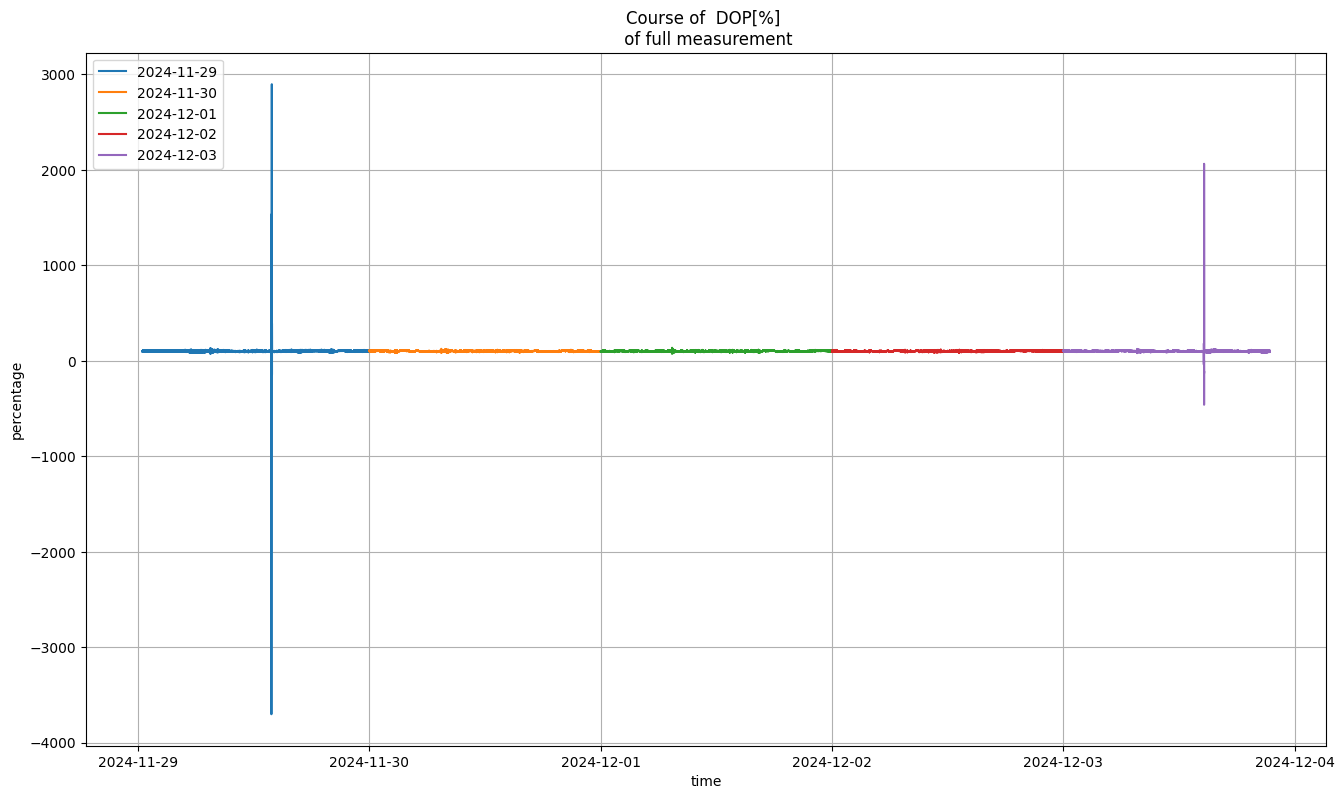

In [13]:
plt.figure(figsize = (16,9))
for date, df_day in degree_daily_list:
    values = df_day
    plt.plot(values, label=str(date))
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Course of {columns[11]}\n of full measurement')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

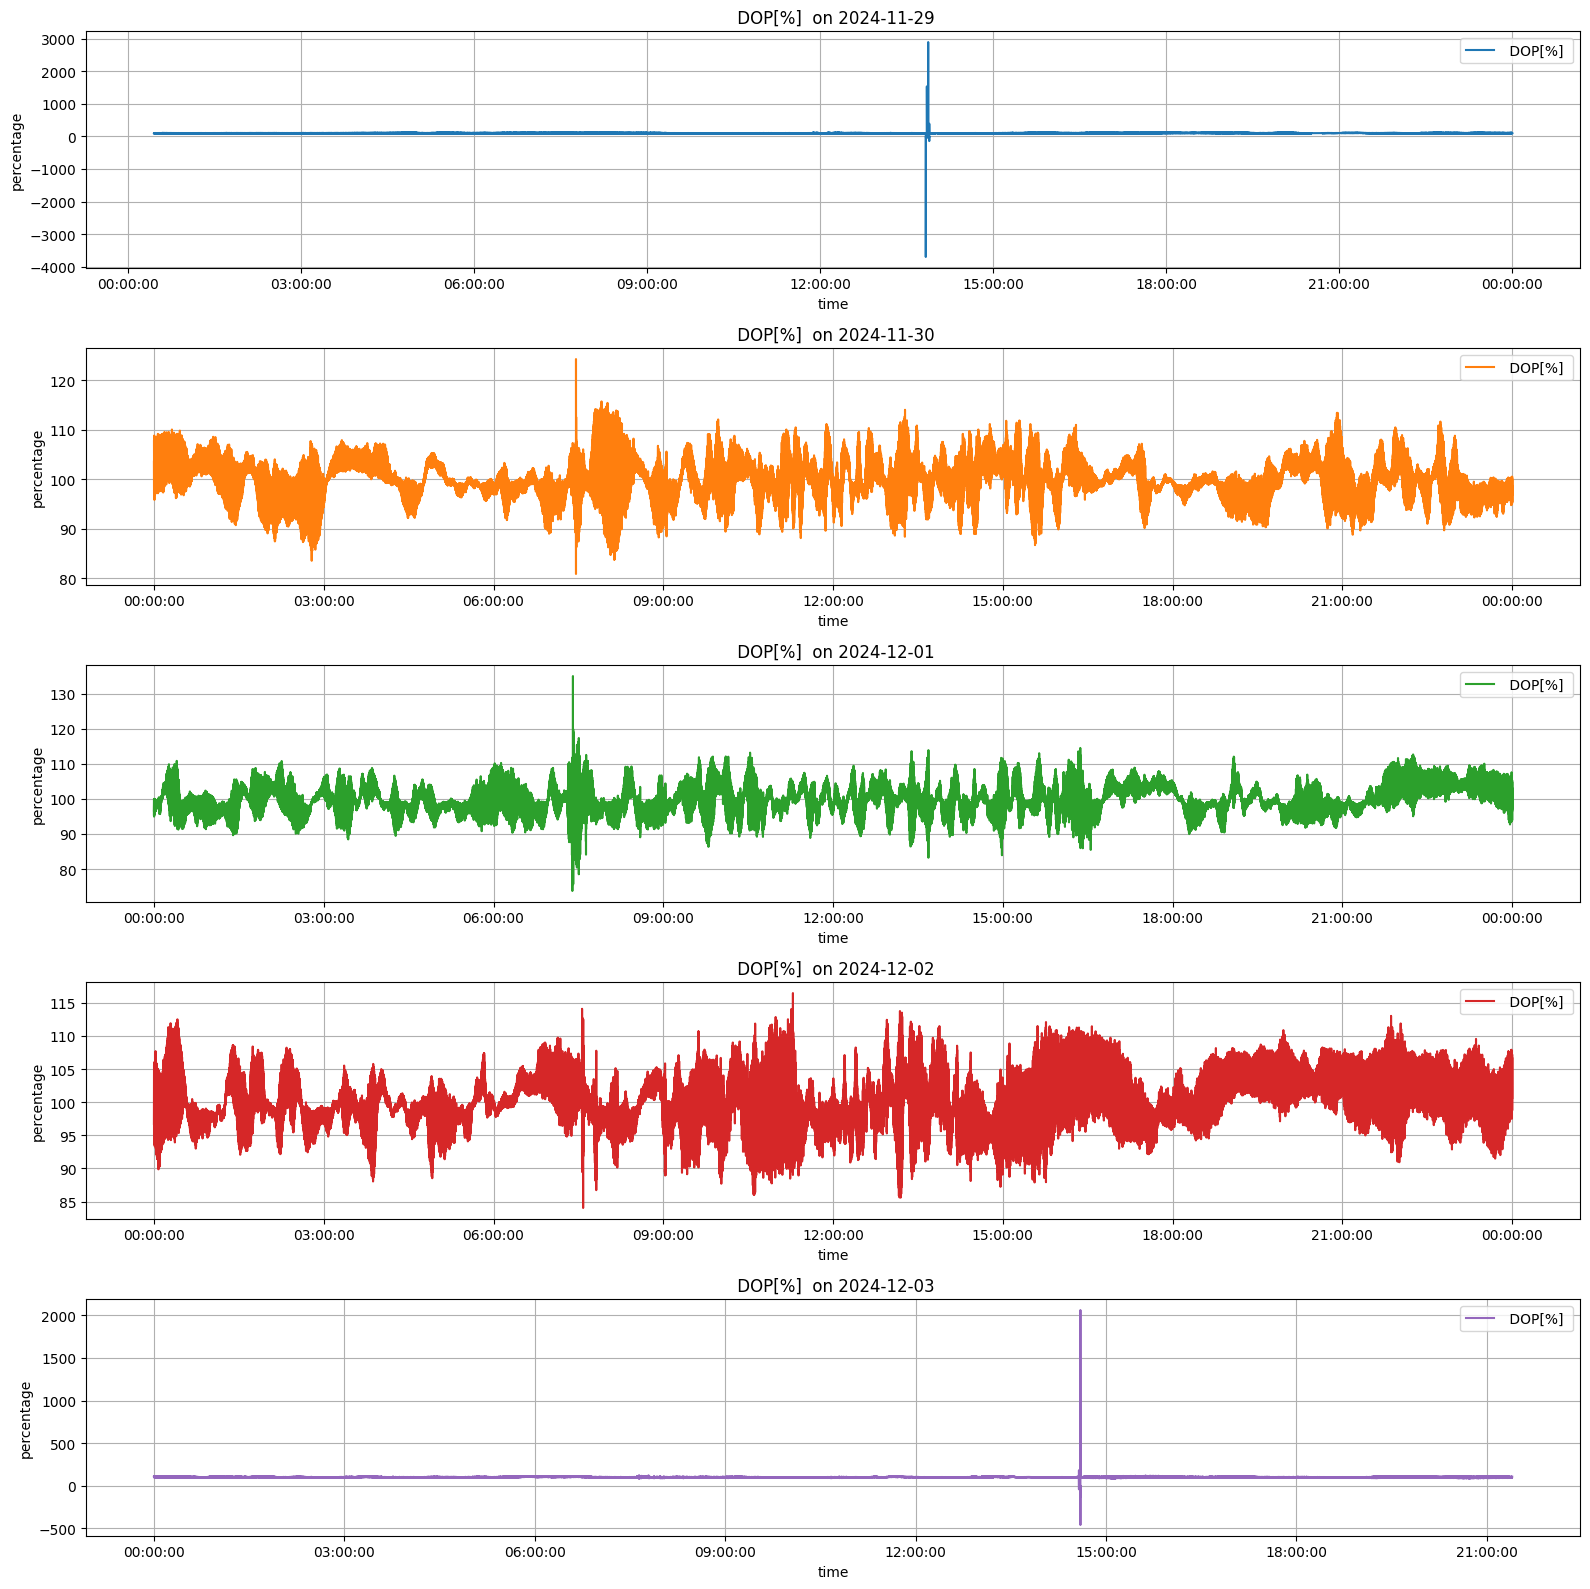

In [14]:
fig, axs = plt.subplots(len(degree_daily_list), 1, figsize=(16, 16), sharex=False)

for i in range(len(degree_daily_list)):
    ax = axs[i] if len(degree_daily_list) > 1 else axs
    df_day = degree_daily_list[i][1]

    ax.plot(df_day.index, df_day, label=columns[11], color=colors[i])
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[11]} on {degree_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('percentage')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

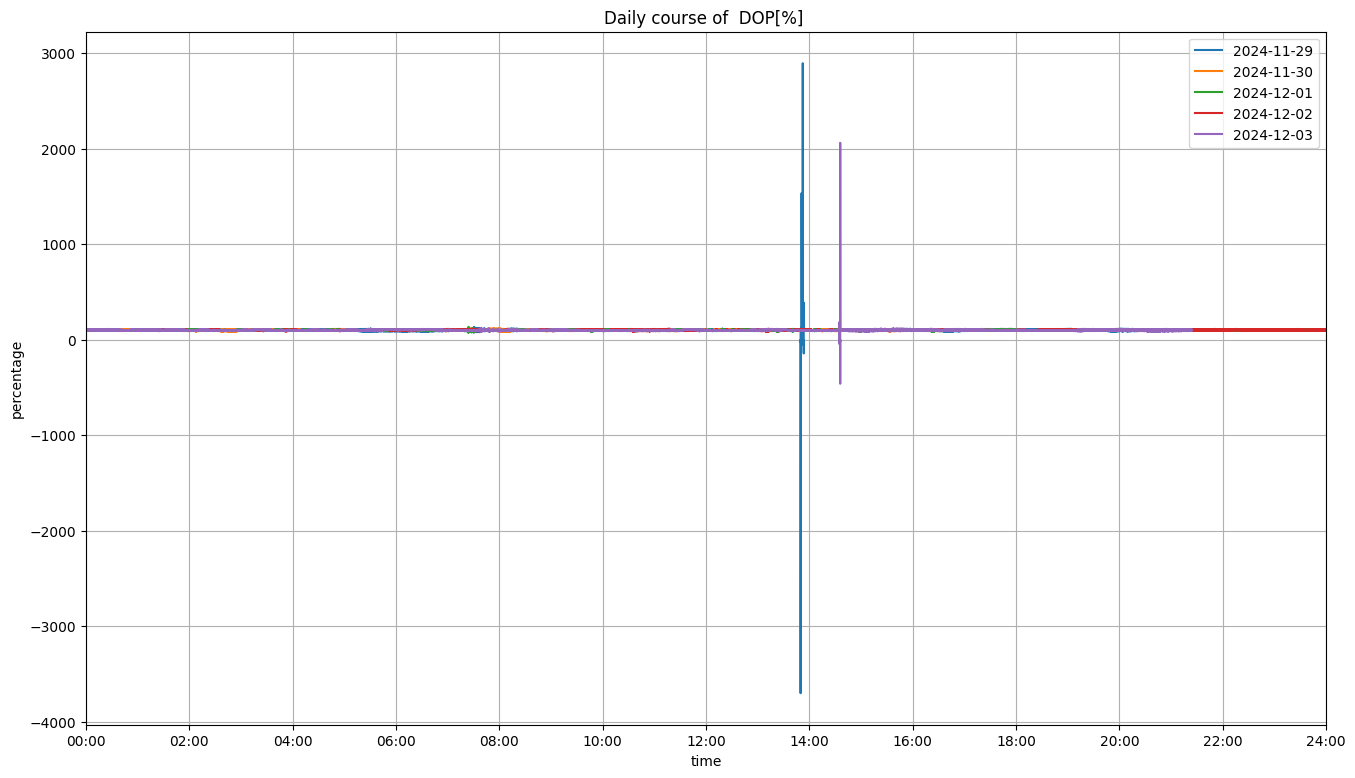

In [15]:
fig, ax = plt.subplots(figsize = (16,9))

for date, df_day in degree_daily_list:
    times = (df_day.index - df_day.index.normalize()).total_seconds()
    values = df_day
    plt.plot(times, values, label=str(date))
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlim(0, 24 * 3600)

plt.grid()
plt.legend(loc = 'best')
plt.title(f'Daily course of {columns[11]}')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

## Stundenweise Aufteilung (Beispiel: erster Tag)

In [16]:
# exemplary day
day = 0 #first day

In [17]:
degree_one_day = degree_daily_list[day][1]
hourly = degree_one_day.groupby(degree_one_day.index.hour)
degree_hourly = list(hourly)

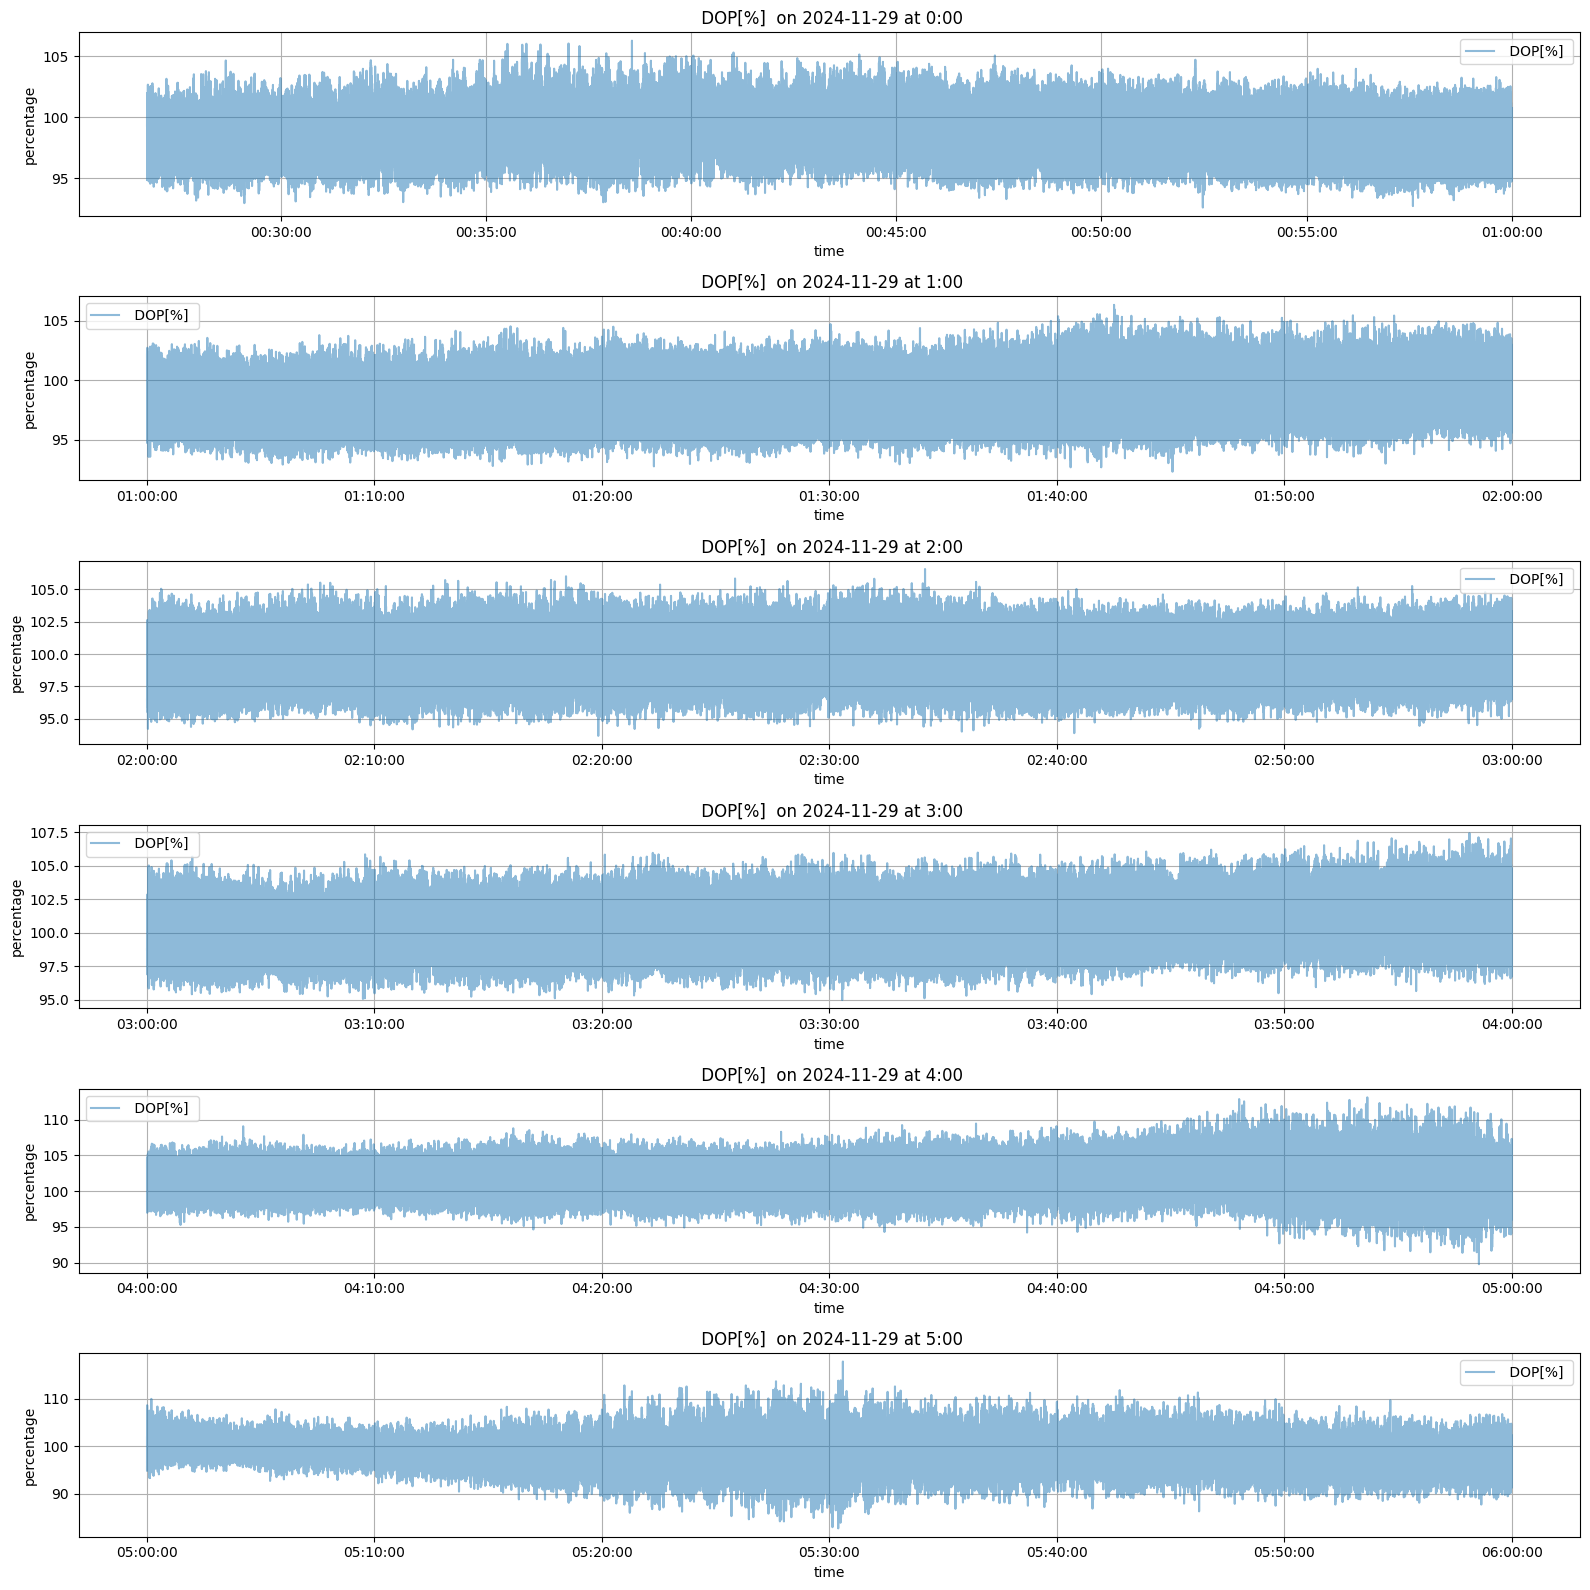

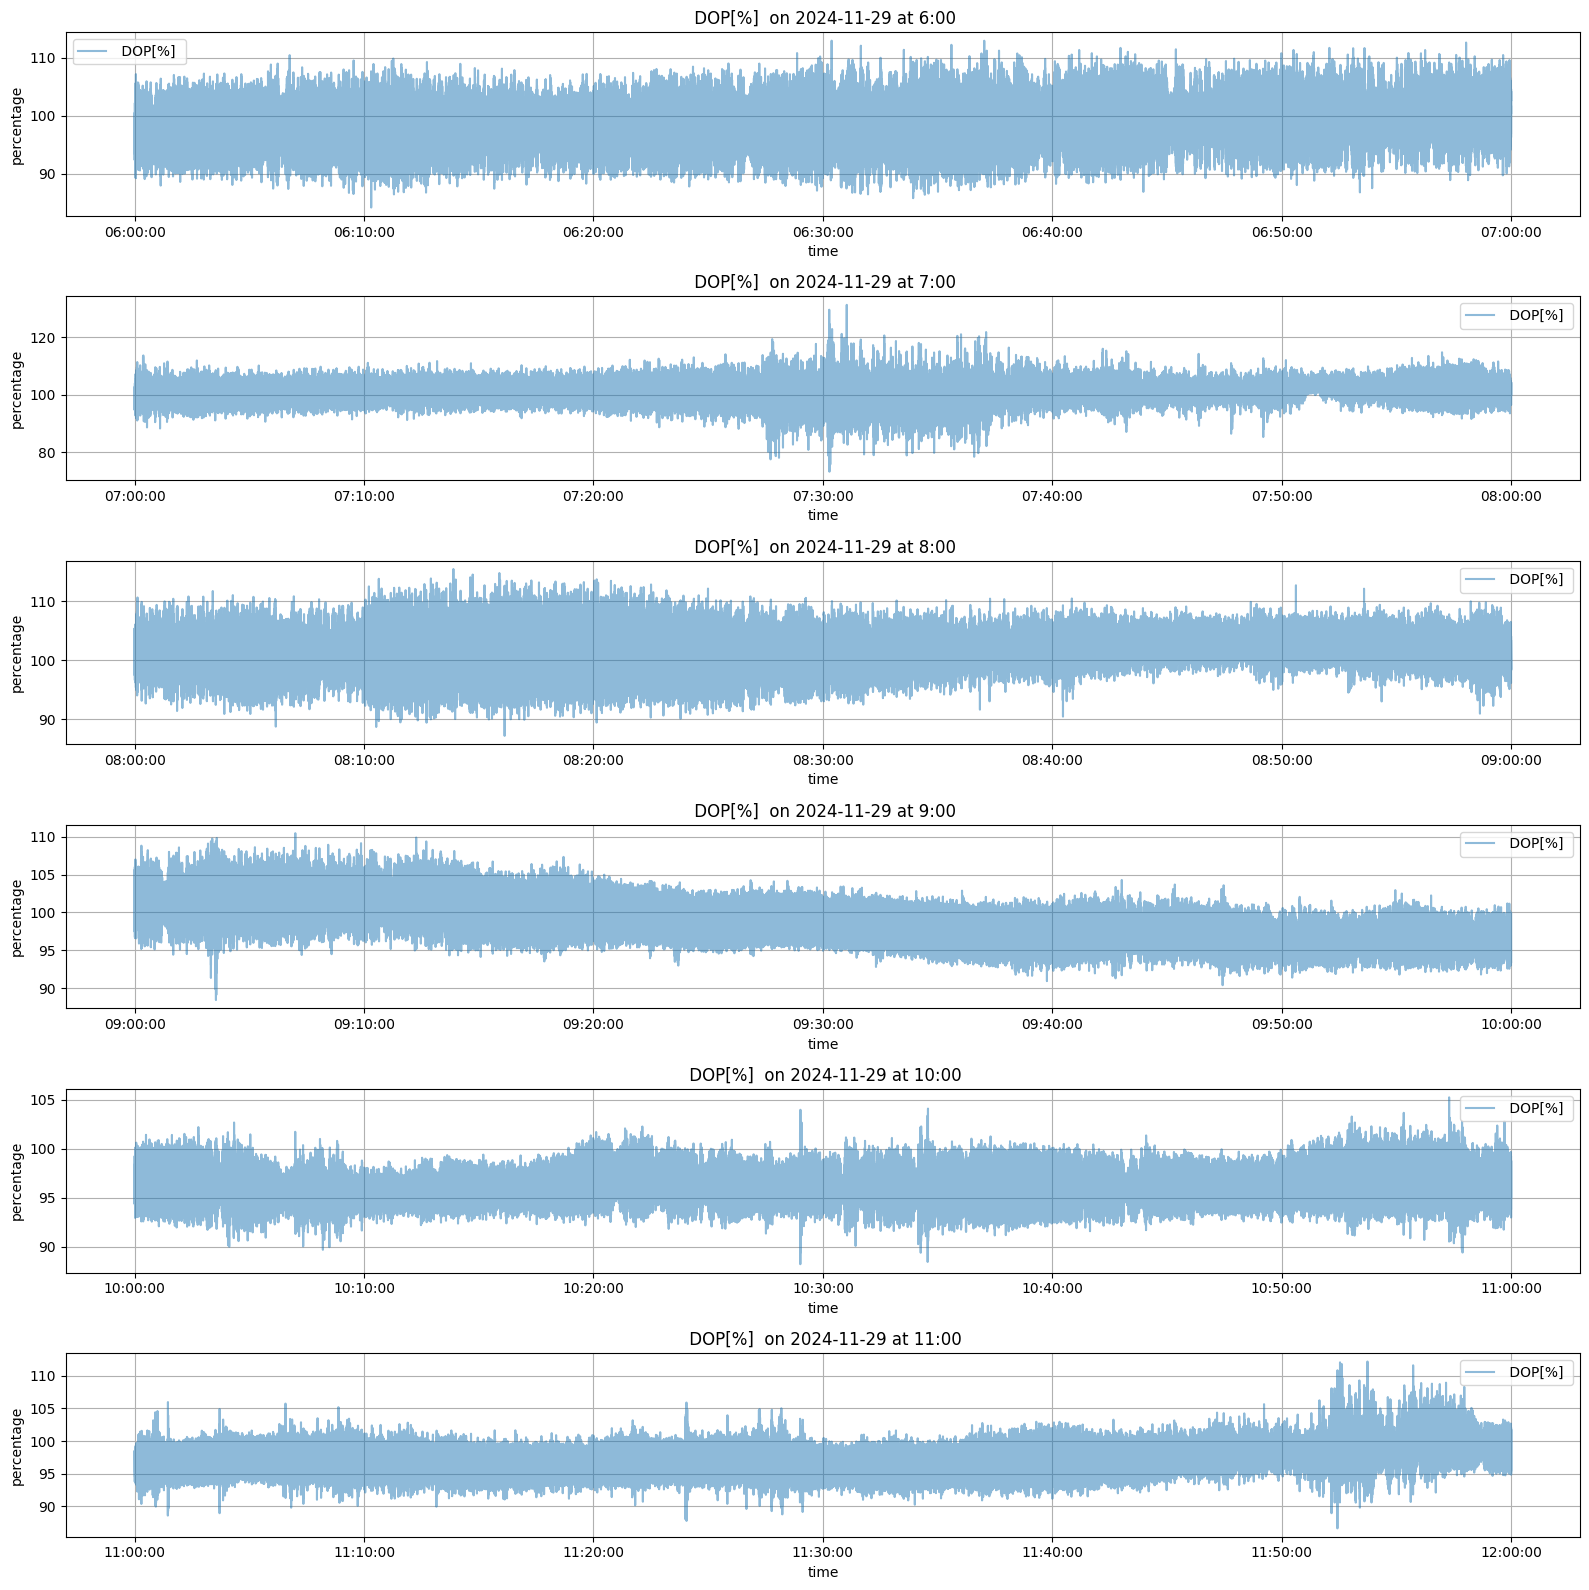

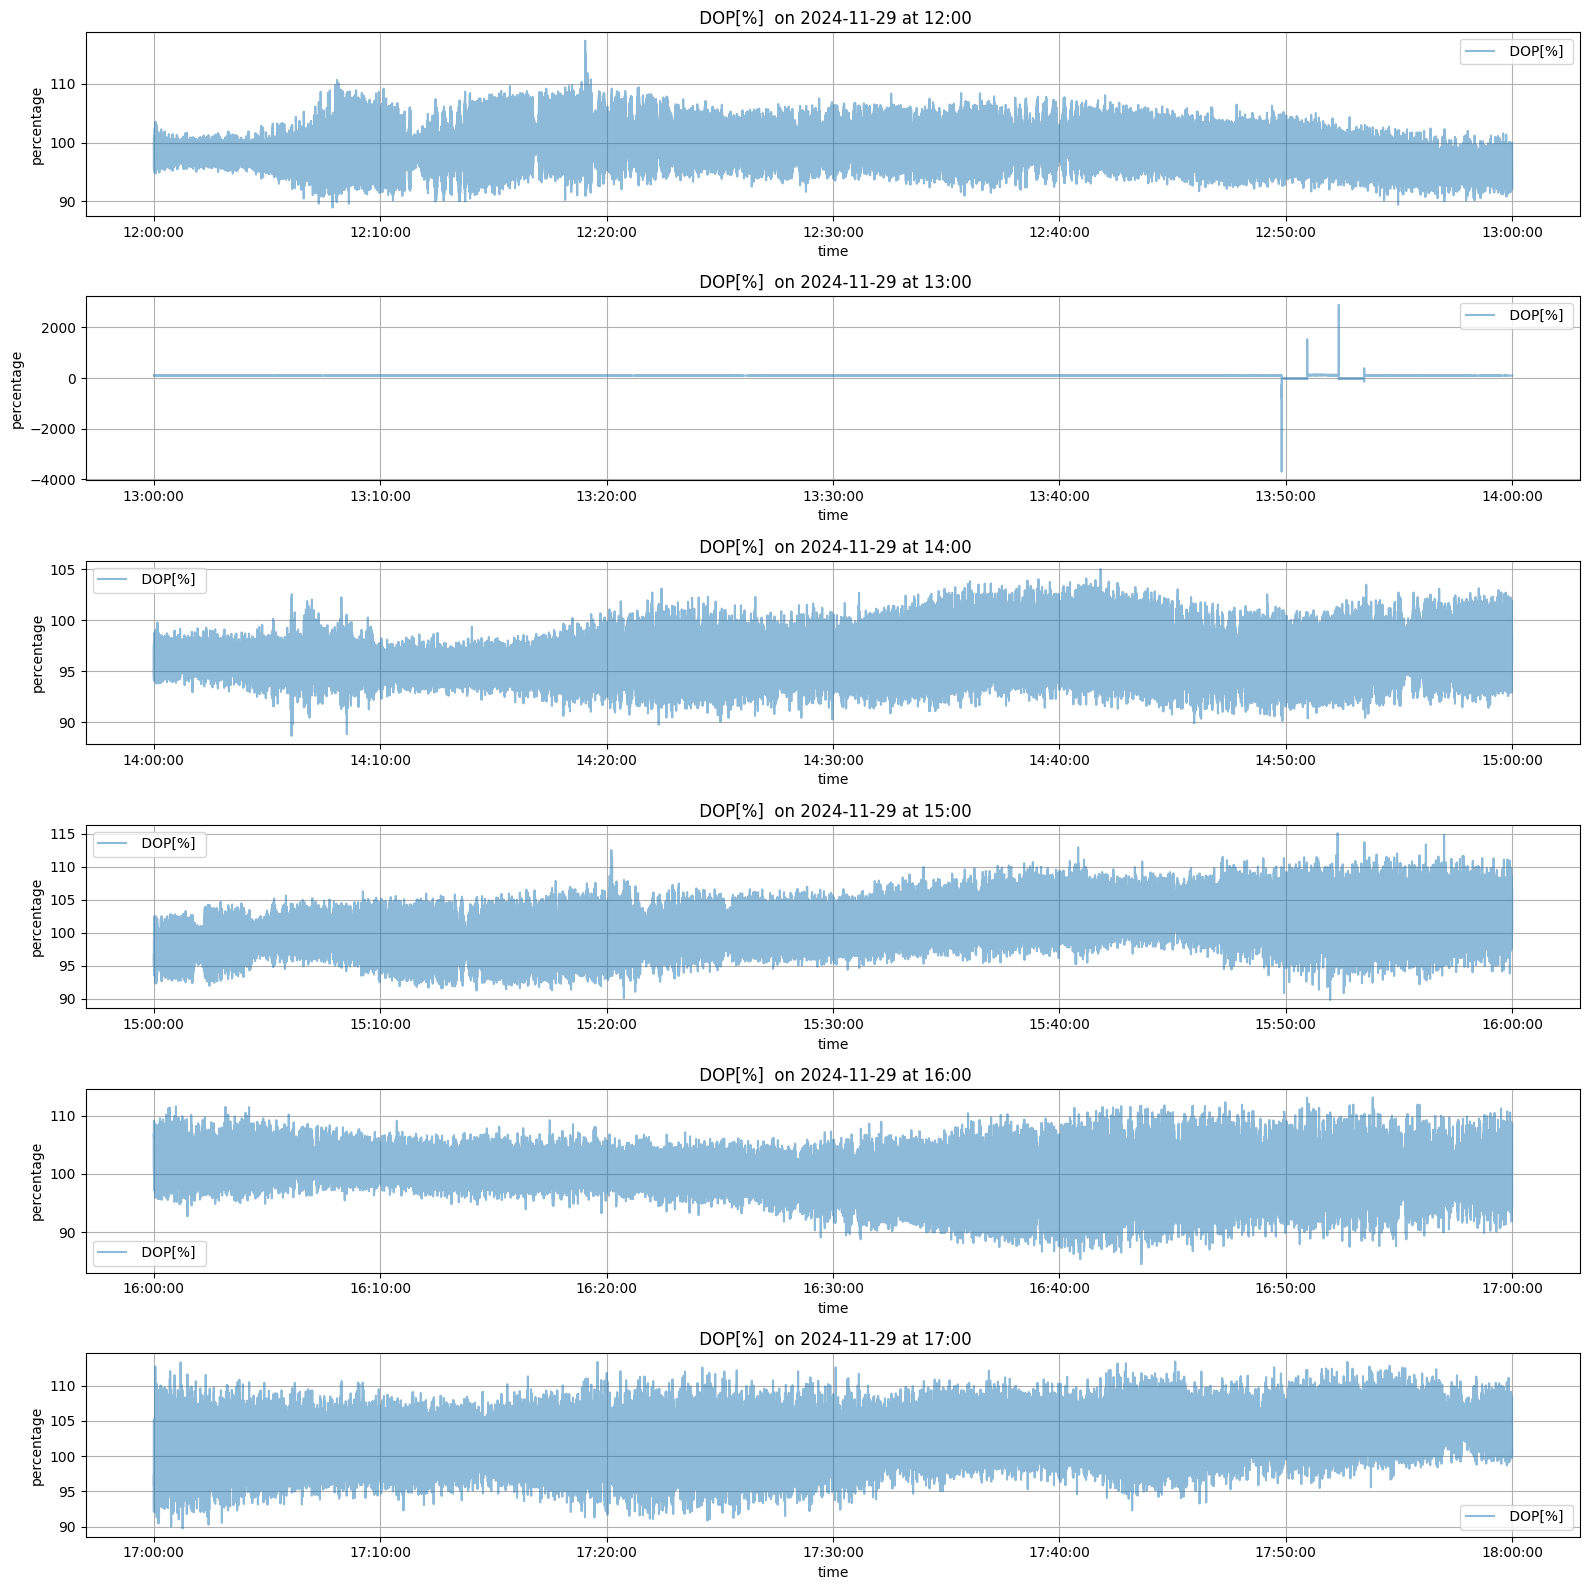

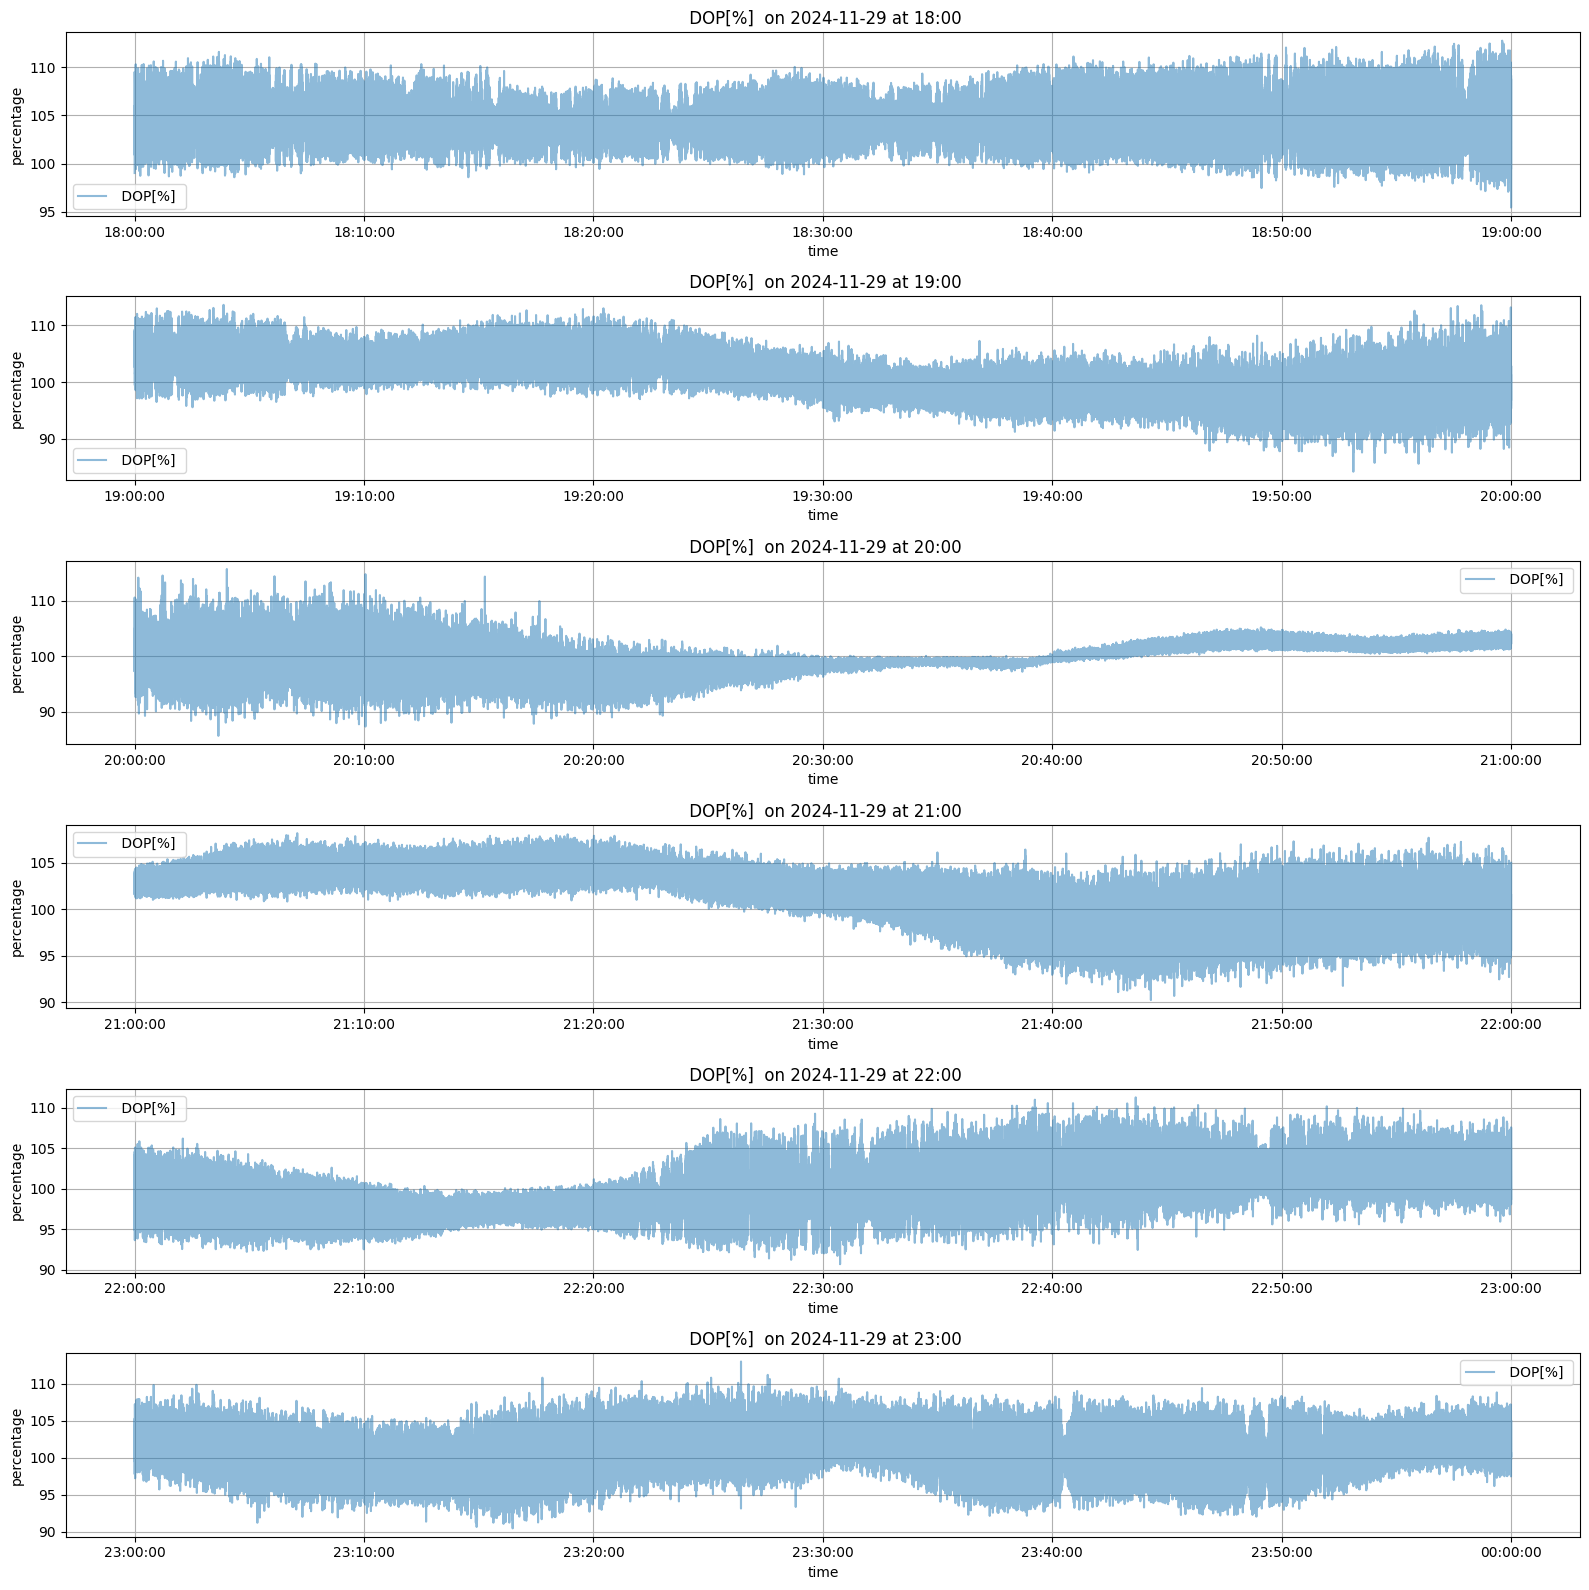

In [18]:
daily_quaters = [degree_hourly[:6], degree_hourly[6:12], degree_hourly[12:18], degree_hourly[18:]]
for quater in daily_quaters:
    fig, axs = plt.subplots(len(quater), 1, figsize=(16, 16), sharex=False)

    for i in range(len(quater)):
        ax = axs[i] if len(quater) > 1 else axs
        df_day = quater[i][1]

        ax.plot(df_day.index, df_day, label=columns[11], color=colors[day], alpha=0.5)
        ax.grid()
        ax.legend(loc='best')
        ax.set_title(f'{columns[11]} on {degree_daily_list[day][0]} at {quater[i][0]}:00')
        ax.set_xlabel('time')
        ax.set_ylabel('percentage')

        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

    plt.tight_layout()
    plt.show()

## Ausreißerbereinigung

In [19]:
new_degree = degree[columns[11]]
new_degree = new_degree.drop(new_degree[(new_degree > 140) | (new_degree < 0)].index)
new_degree.describe()

count    7.088521e+06
mean     9.974852e+01
std      3.296249e+00
min      7.314000e+01
25%      9.738000e+01
50%      9.950000e+01
75%      1.021600e+02
max      1.350300e+02
Name:  DOP[%] , dtype: float64

In [20]:
new_degree_daily = new_degree.groupby(new_degree.index.date)
new_degree_daily_list = list(new_degree_daily)

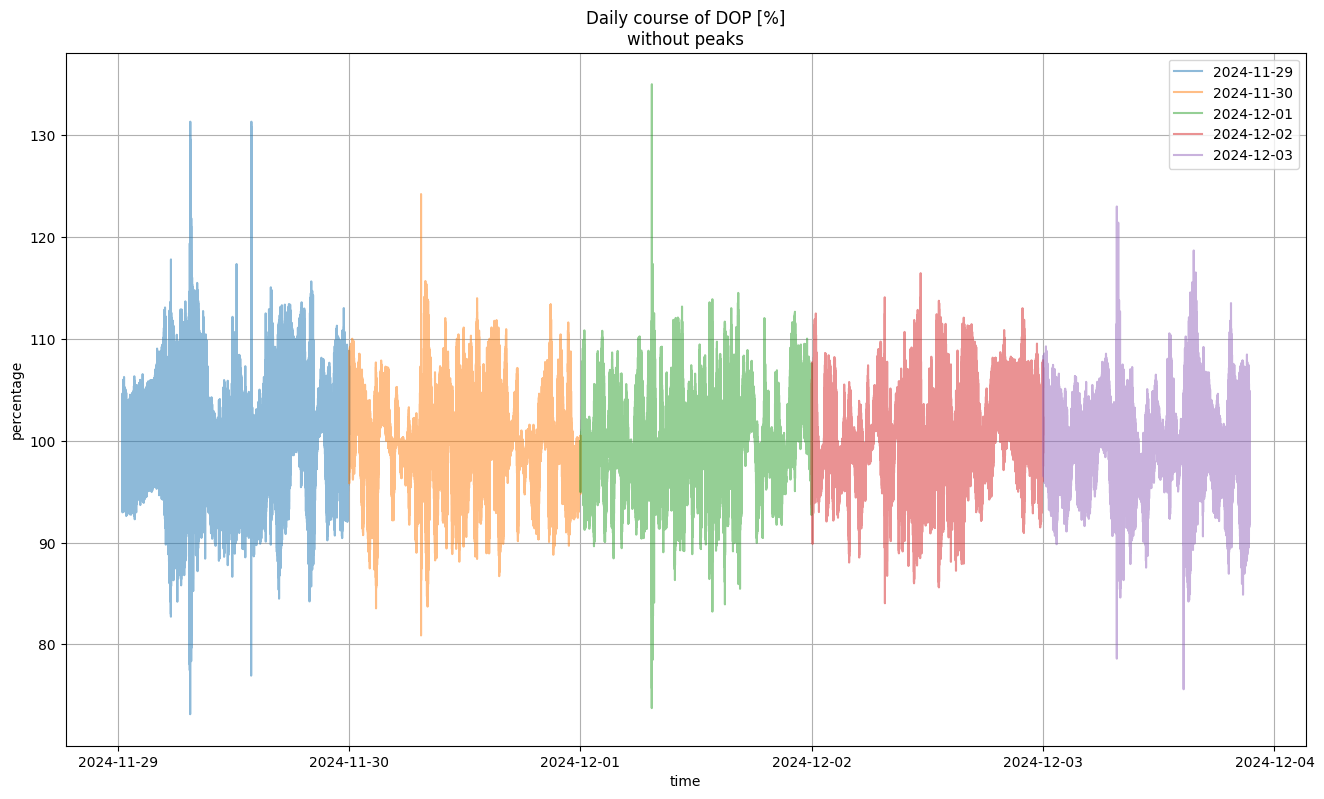

In [21]:
plt.figure(figsize = (16,9))
for date, df_day in new_degree_daily_list:
    values = df_day
    plt.plot(values, label=str(date), alpha = 0.5)
plt.grid()
plt.legend(loc = 'best')
plt.title('Daily course of DOP [%]\nwithout peaks')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

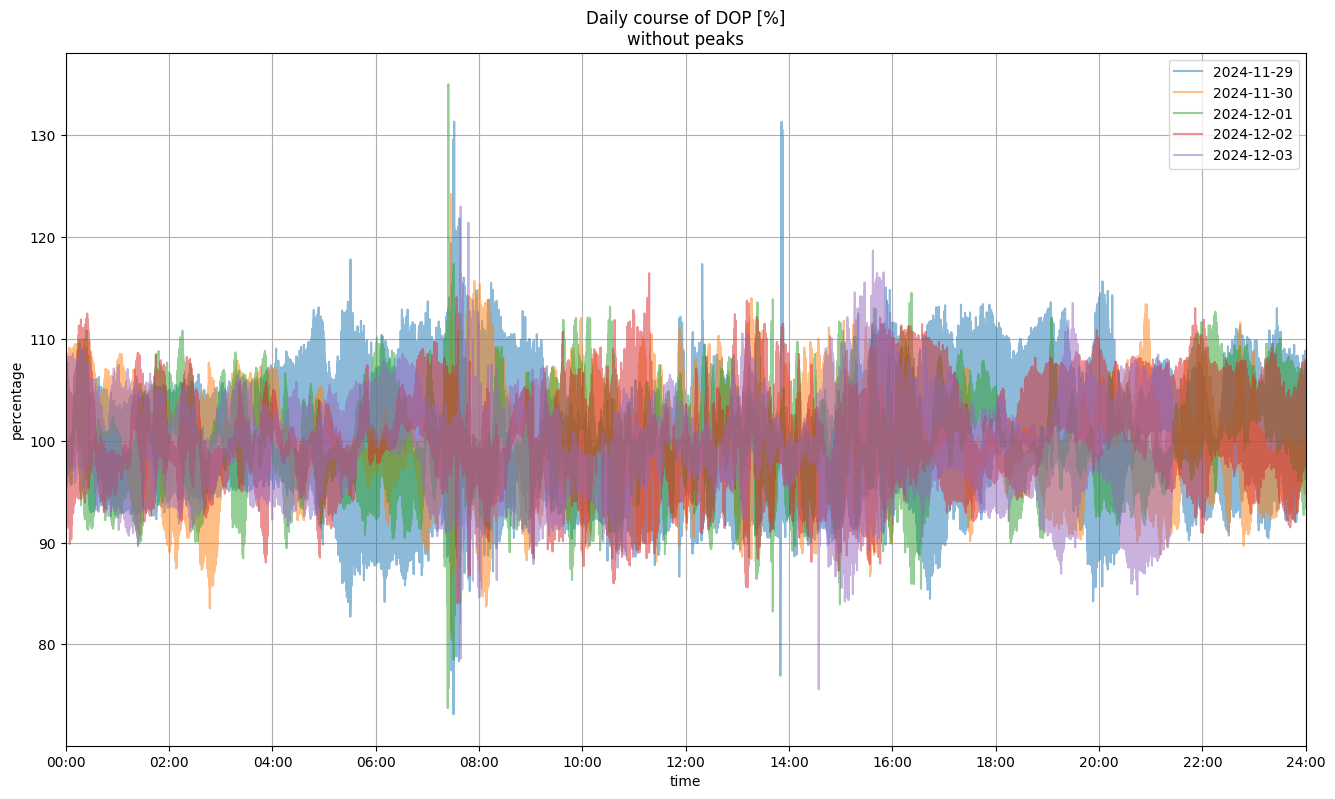

In [22]:
fig, ax = plt.subplots(figsize = (16,9))

for date, df_day in new_degree_daily_list:
    times = (df_day.index - df_day.index.normalize()).total_seconds()
    values = df_day
    plt.plot(times, values, label=str(date) , alpha=0.5)
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlim(0, 24 * 3600)

plt.grid()
plt.legend(loc = 'best')
plt.title('Daily course of DOP [%]\nwithout peaks')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

## Tägliche Normalverteilung mit Histogramm

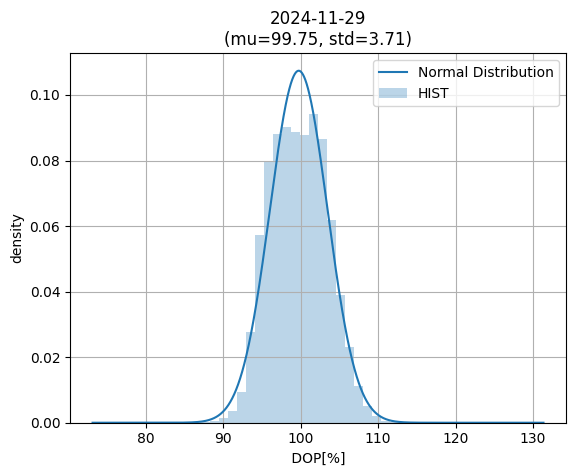

In [23]:
ydata1 = np.array(new_degree_daily_list[day][1])
mu1 = np.mean(ydata1)
sigma1 = np.std(ydata1)
x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
y1 = norm.pdf(x1, mu1, sigma1)  

plt.plot(x1, y1, label = 'Normal Distribution', color=colors[day])
plt.hist(ydata1, bins = 50, density = True, color=colors[day], alpha = 0.3, label = "HIST")

plt.title(f'{new_degree_daily_list[day][0]}\n(mu={mu1:.2f}, std={sigma1:.2f})')
plt.legend(loc = 'best')
plt.xlabel(columns[11])
plt.ylabel('density')
plt.grid()
plt.show()

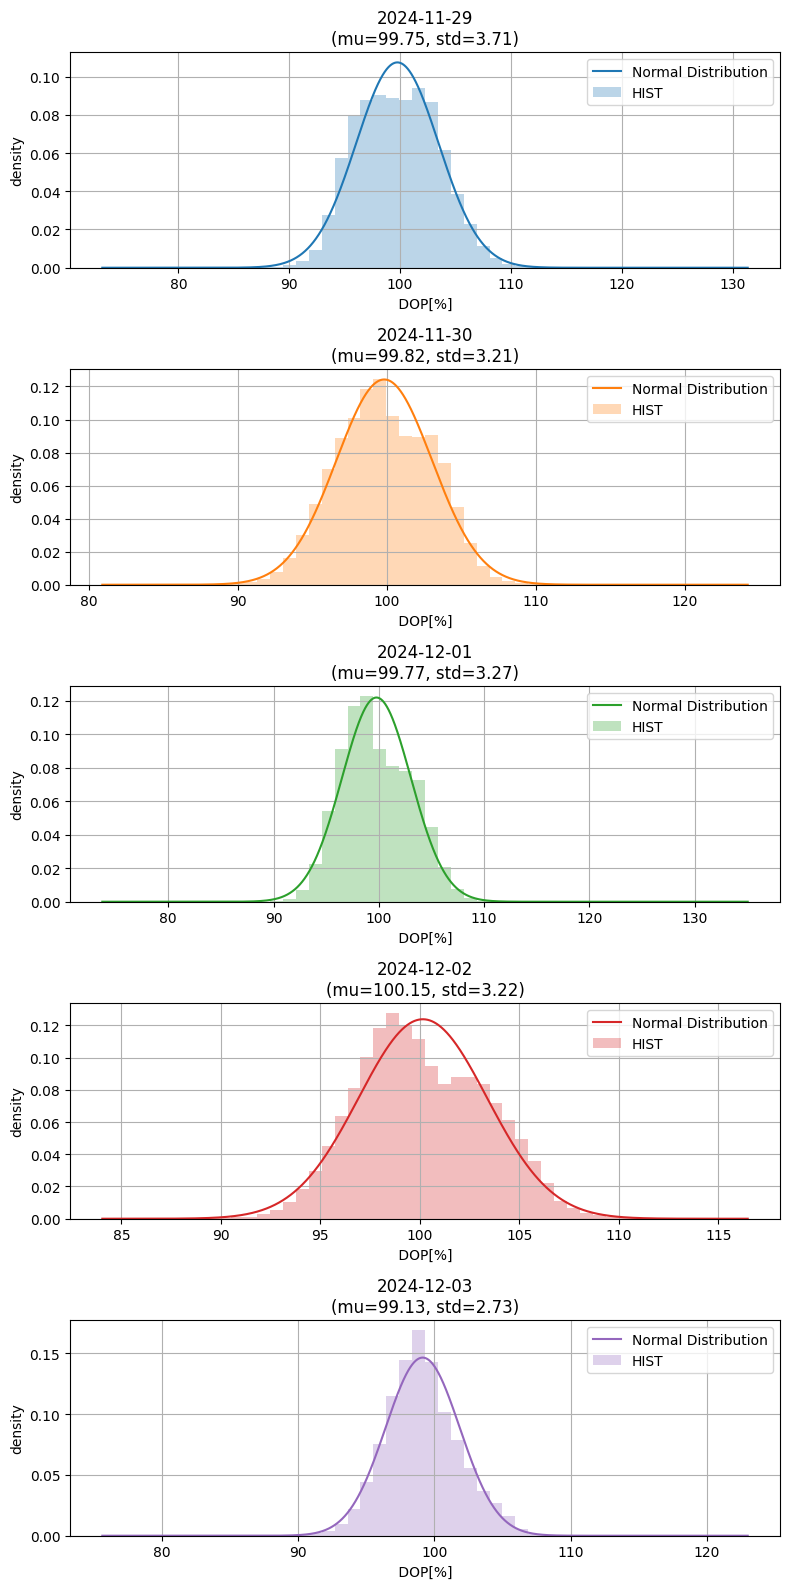

In [24]:
fig, axs = plt.subplots(len(new_degree_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(new_degree_daily_list)):
    ax = axs[i] if len(new_degree_daily_list) > 1 else axs
    ydata1 = np.array(new_degree_daily_list[i][1])
    mu1 = np.mean(ydata1)
    sigma1 = np.std(ydata1)
    x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
    y1 = norm.pdf(x1, mu1, sigma1)  

    ax.plot(x1, y1, label = 'Normal Distribution', color=colors[i])
    ax.hist(ydata1, bins = 50, density = True, color=colors[i], alpha = 0.3, label = "HIST")
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{degree_daily_list[i][0]}\n(mu={mu1:.2f}, std={sigma1:.2f})')
    ax.set_xlabel(columns[11])
    ax.set_ylabel('density')

plt.tight_layout()
plt.show()

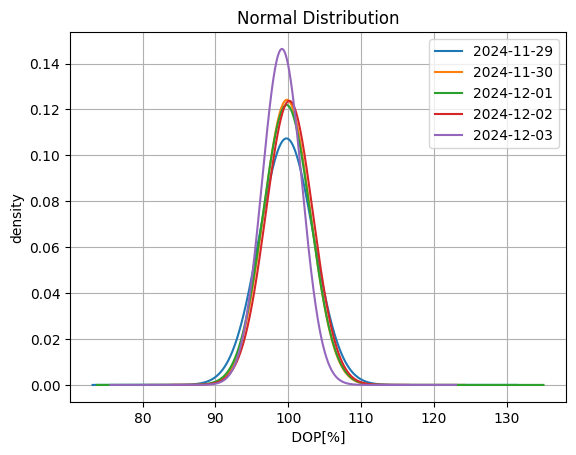

In [25]:
for i in range(len(new_degree_daily_list)):
    ydata1 = np.array(new_degree_daily_list[i][1])
    mu1 = np.mean(ydata1)
    sigma1 = np.std(ydata1)
    x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
    y1 = norm.pdf(x1, mu1, sigma1)  

    plt.plot(x1, y1, label = new_degree_daily_list[i][0])
    
plt.title(f'Normal Distribution')
plt.legend(loc = 'best')
plt.xlabel(columns[11])
plt.ylabel('density')
plt.grid()
plt.show()

## Filterung mittels Tief- und Hochpass

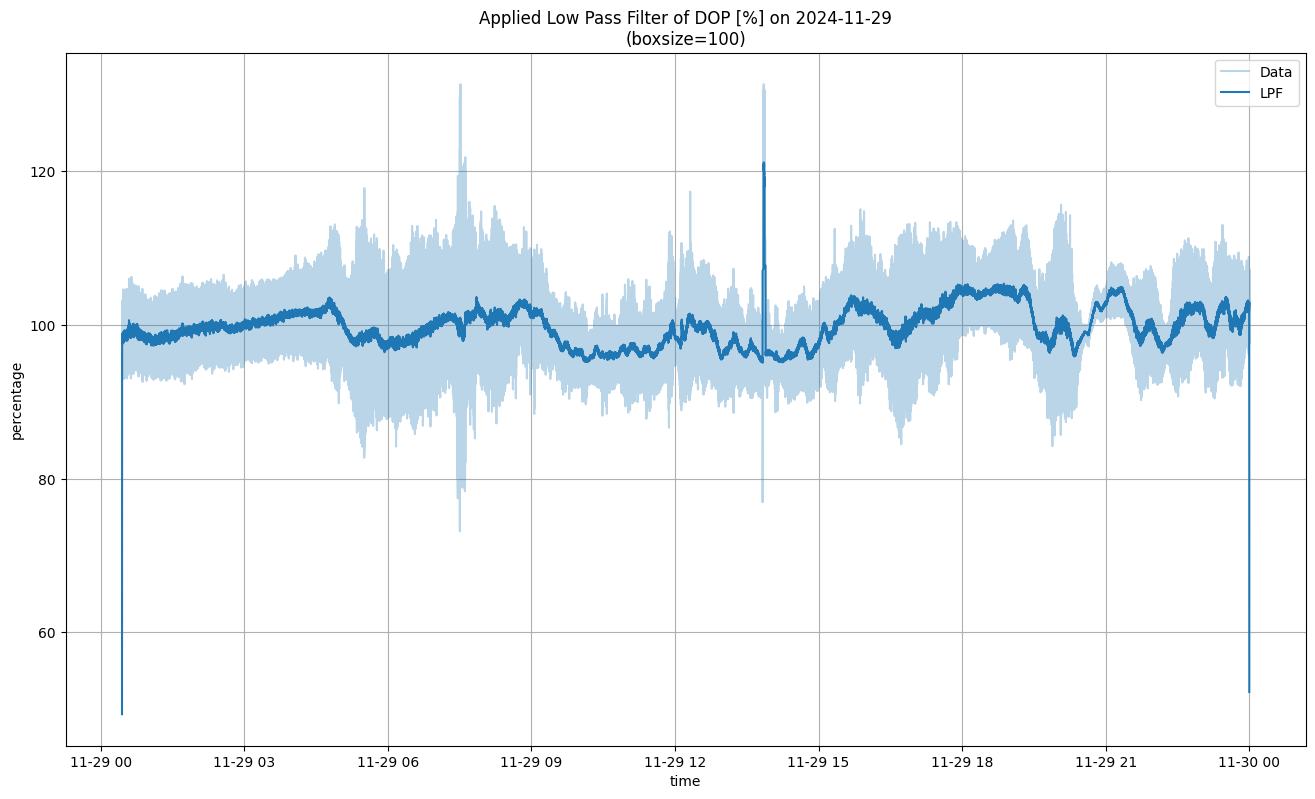

In [28]:
box = 100

time = new_degree_daily_list[day][1].index
ydata = np.array(new_degree_daily_list[day][1])
lps = lowpass(ydata, box)

plt.figure(figsize = (16,9))
plt.plot(time, ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(time, lps[:-1], label = 'LPF', color = colors[day])
plt.title(f'Applied Low Pass Filter of DOP [%] on {new_degree_daily_list[day][0]}\n(boxsize={box})')
plt.xlabel('time')
plt.ylabel('percentage')
plt.grid()
plt.legend(loc = 'best')
plt.show()

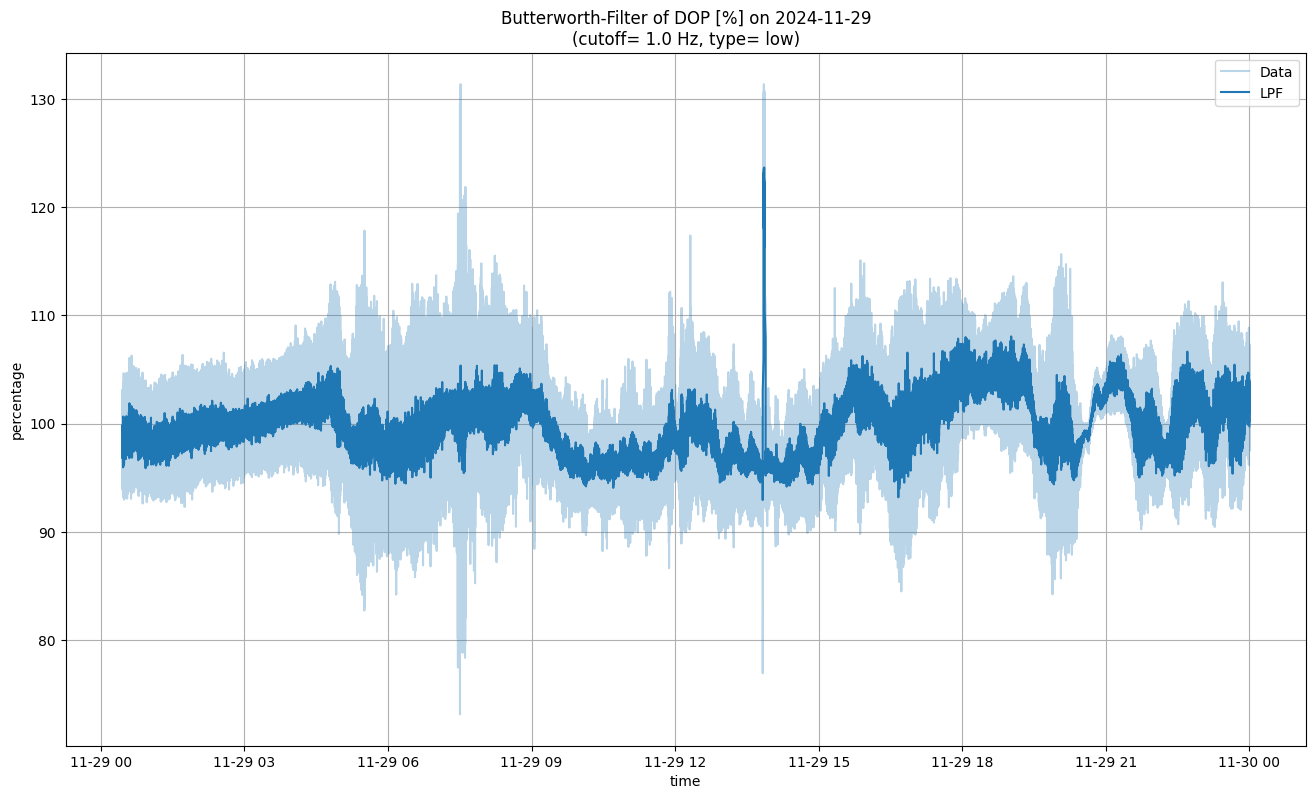

In [30]:
cutoff = 1.0
btype='low'

time = new_degree_daily_list[day][1].index
ydata = np.array(new_degree_daily_list[day][1])
lps = butter_filter(ydata, cutoff = cutoff, btype=btype)

plt.figure(figsize = (16,9))
plt.plot(time, ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(time, lps, label = 'LPF', color = colors[day])
plt.title(f'Butterworth-Filter of DOP [%] on {new_degree_daily_list[day][0]}\n(cutoff= {cutoff} Hz, type= {btype})')
plt.xlabel('time')
plt.ylabel('percentage')
plt.grid()
plt.legend(loc = 'best')
plt.show()

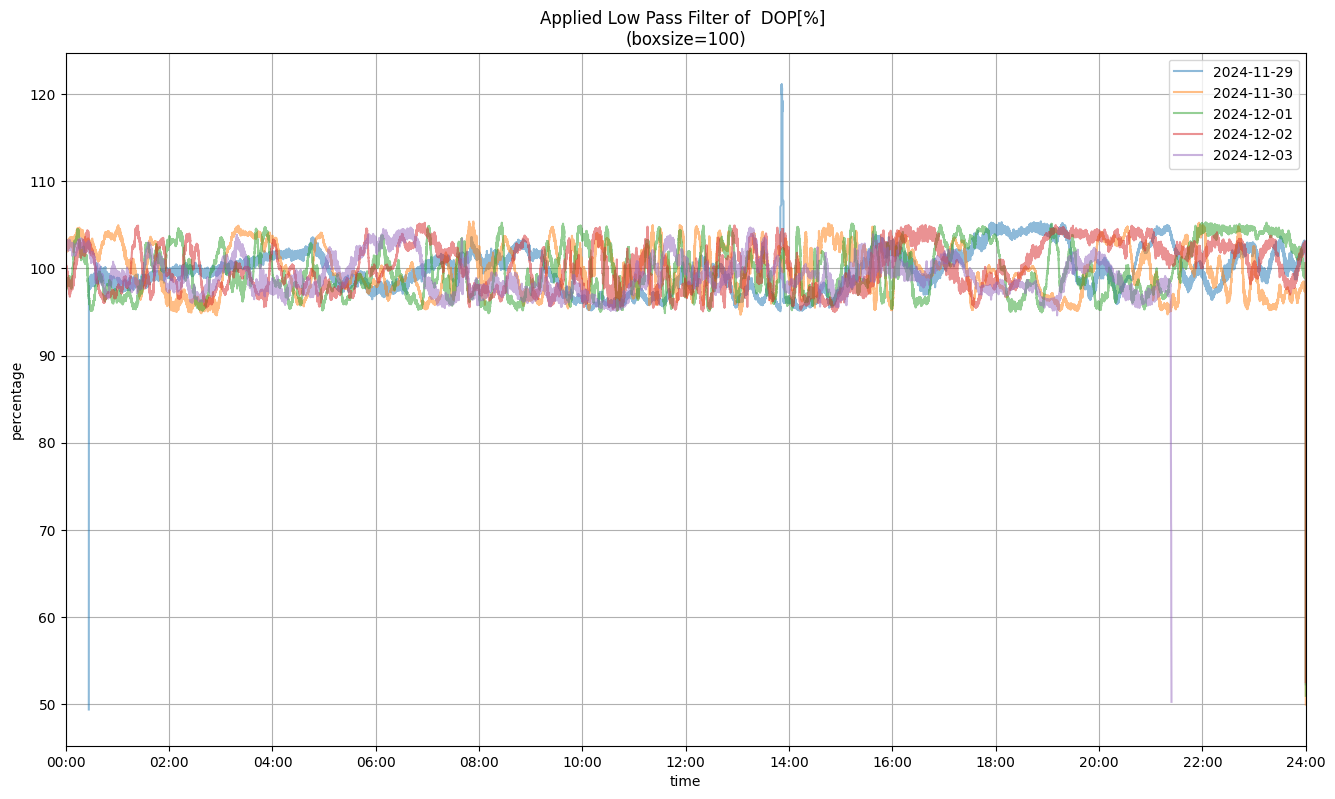

In [31]:
box = 100

fig, ax = plt.subplots(figsize = (16,9))

for date, df_day in new_degree_daily_list:
    times = (df_day.index - df_day.index.normalize()).total_seconds()
    ydata = np.array(df_day)
    lps = lowpass(ydata, box)
    plt.plot(times, lps[:-1], label=str(date) , alpha=0.5)
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlim(0, 24 * 3600)

plt.grid()
plt.legend(loc = 'best')
plt.title(f'Applied Low Pass Filter of {columns[11]}\n(boxsize={box})')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

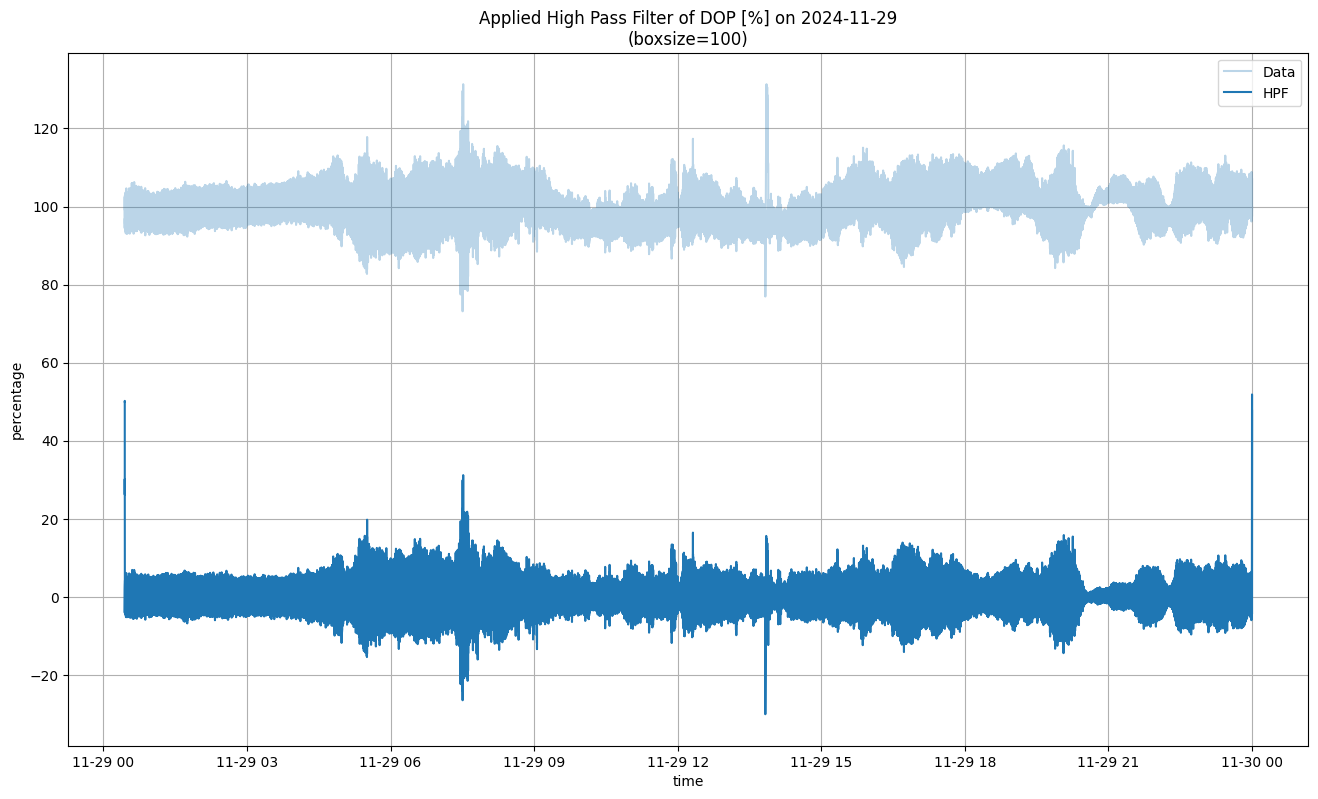

In [32]:
box = 100

time = new_degree_daily_list[day][1].index
ydata = np.array(new_degree_daily_list[day][1])
hps = highpass(ydata, box)

plt.figure(figsize = (16,9))
plt.plot(time, ydata, label = 'Data', color=colors[day], alpha=0.3)
plt.plot(time, hps, label = 'HPF', color=colors[day])
plt.title(f'Applied High Pass Filter of DOP [%] on {new_degree_daily_list[day][0]}\n(boxsize={box})')
plt.xlabel('time')
plt.ylabel('percentage')
plt.grid()
plt.legend(loc = 'best')
plt.show()

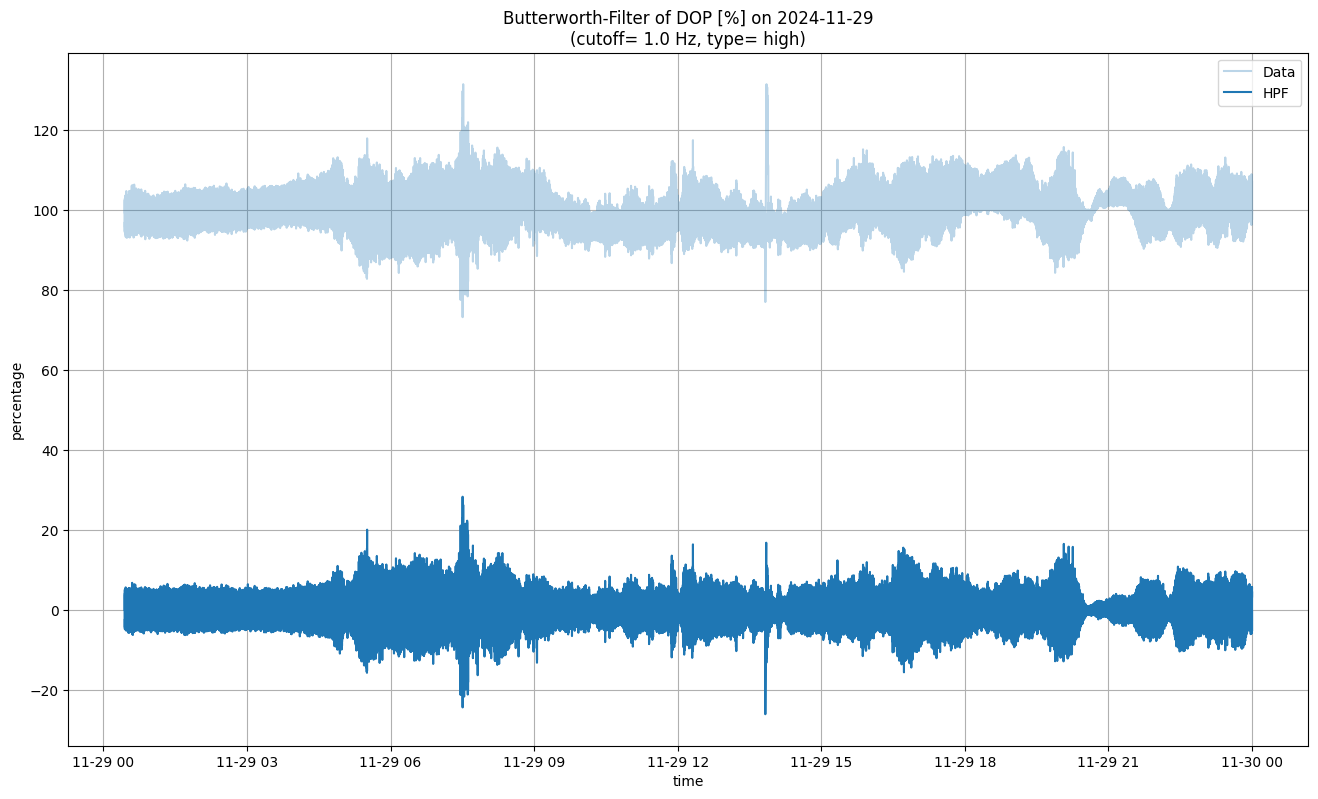

In [33]:
cutoff = 1.0
btype='high'

time = new_degree_daily_list[day][1].index
ydata = np.array(new_degree_daily_list[day][1])
hps = butter_filter(ydata, cutoff = cutoff, btype=btype)

plt.figure(figsize = (16,9))
plt.plot(time, ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(time, hps, label = 'HPF', color = colors[day])
plt.title(f'Butterworth-Filter of DOP [%] on {new_degree_daily_list[day][0]}\n(cutoff= {cutoff} Hz, type= {btype})')
plt.xlabel('time')
plt.ylabel('percentage')
plt.grid()
plt.legend(loc = 'best')
plt.show()

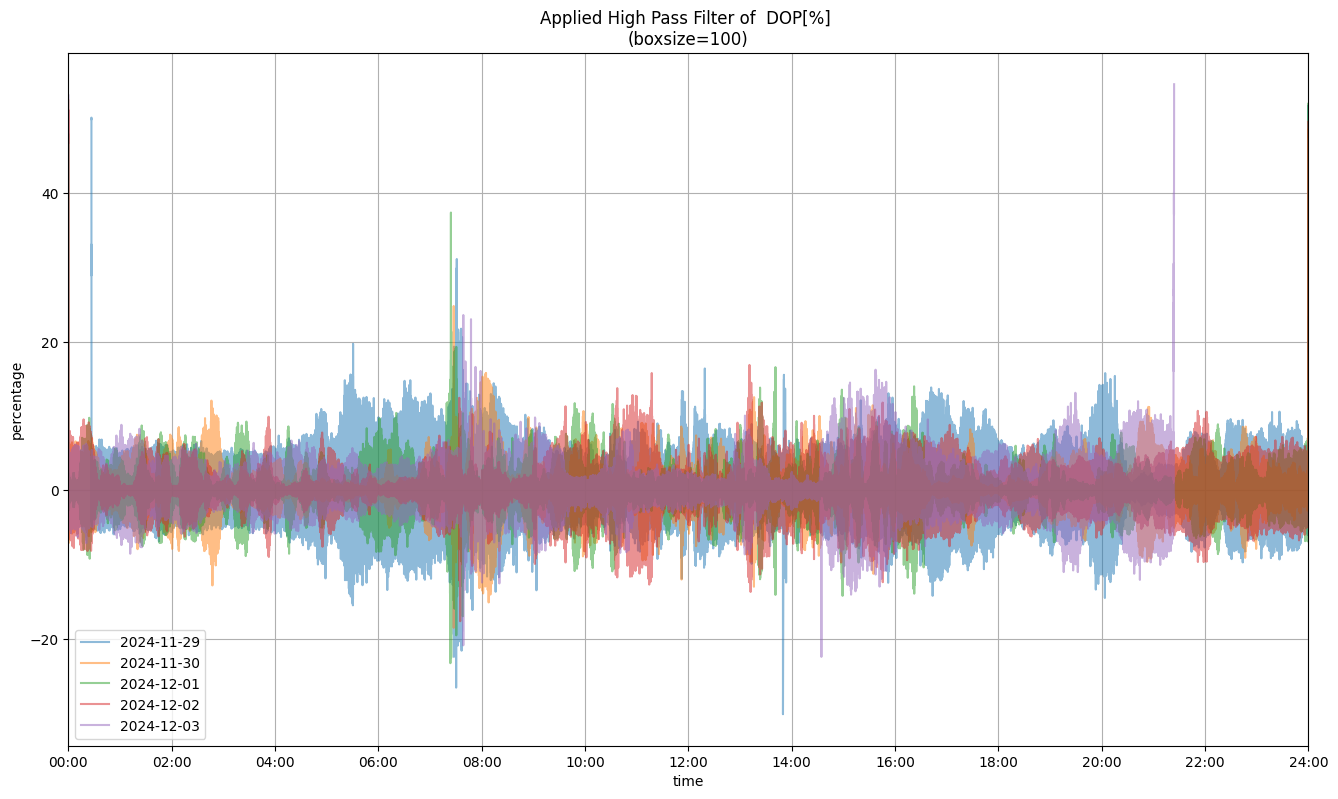

In [34]:
box = 100

fig, ax = plt.subplots(figsize = (16,9))

for date, df_day in new_degree_daily_list:
    times = (df_day.index - df_day.index.normalize()).total_seconds()
    ydata = np.array(df_day)
    hps = highpass(ydata, box)
    plt.plot(times, hps, label=str(date) , alpha=0.5)
    

ax.xaxis.set_major_locator(ticker.MultipleLocator(3600 * 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(format_time))
ax.set_xlim(0, 24 * 3600)

plt.grid()
plt.legend(loc = 'best')
plt.title(f'Applied High Pass Filter of {columns[11]}\n(boxsize={box})')
plt.xlabel('time')
plt.ylabel('percentage')
plt.show()

# Winkelparameter (Azimuth [°], Ellipticity [°])

In [35]:
angle = pd.read_csv(filename,skiprows=skip, sep=sep, usecols=[columns[0], columns[9], columns[10]])

In [36]:
angle[columns[0]] = pd.to_datetime(angle[columns[0]])
angle.set_index(columns[0], inplace=True)

## Tägliche Aufteilung der Messdaten

In [37]:
angle_daily = angle.groupby(angle.index.date)
angle_daily_list = list(angle_daily)

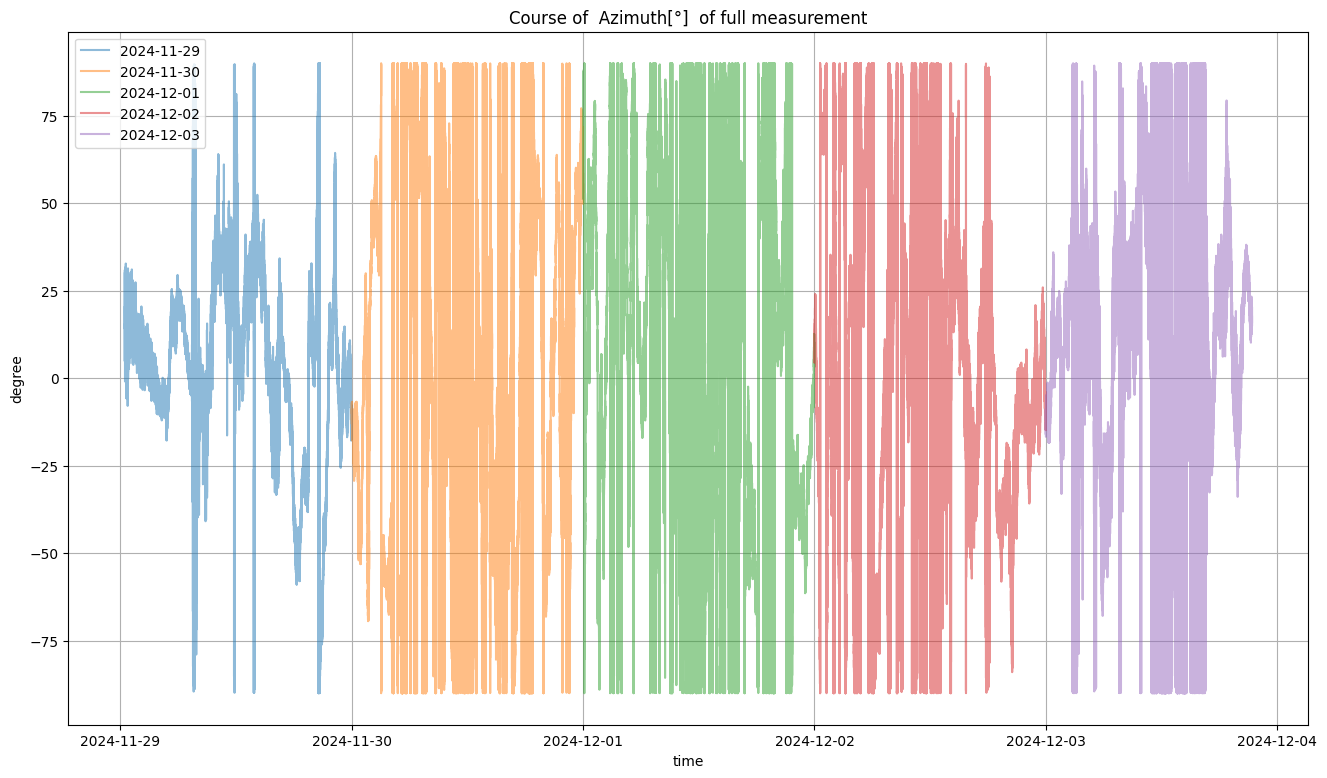

In [38]:
plt.figure(figsize = (16,9))
for date, df_day in angle_daily_list:
    values = df_day[columns[9]]
    plt.plot(values, label=str(date), alpha=0.5)
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Course of {columns[9]} of full measurement')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

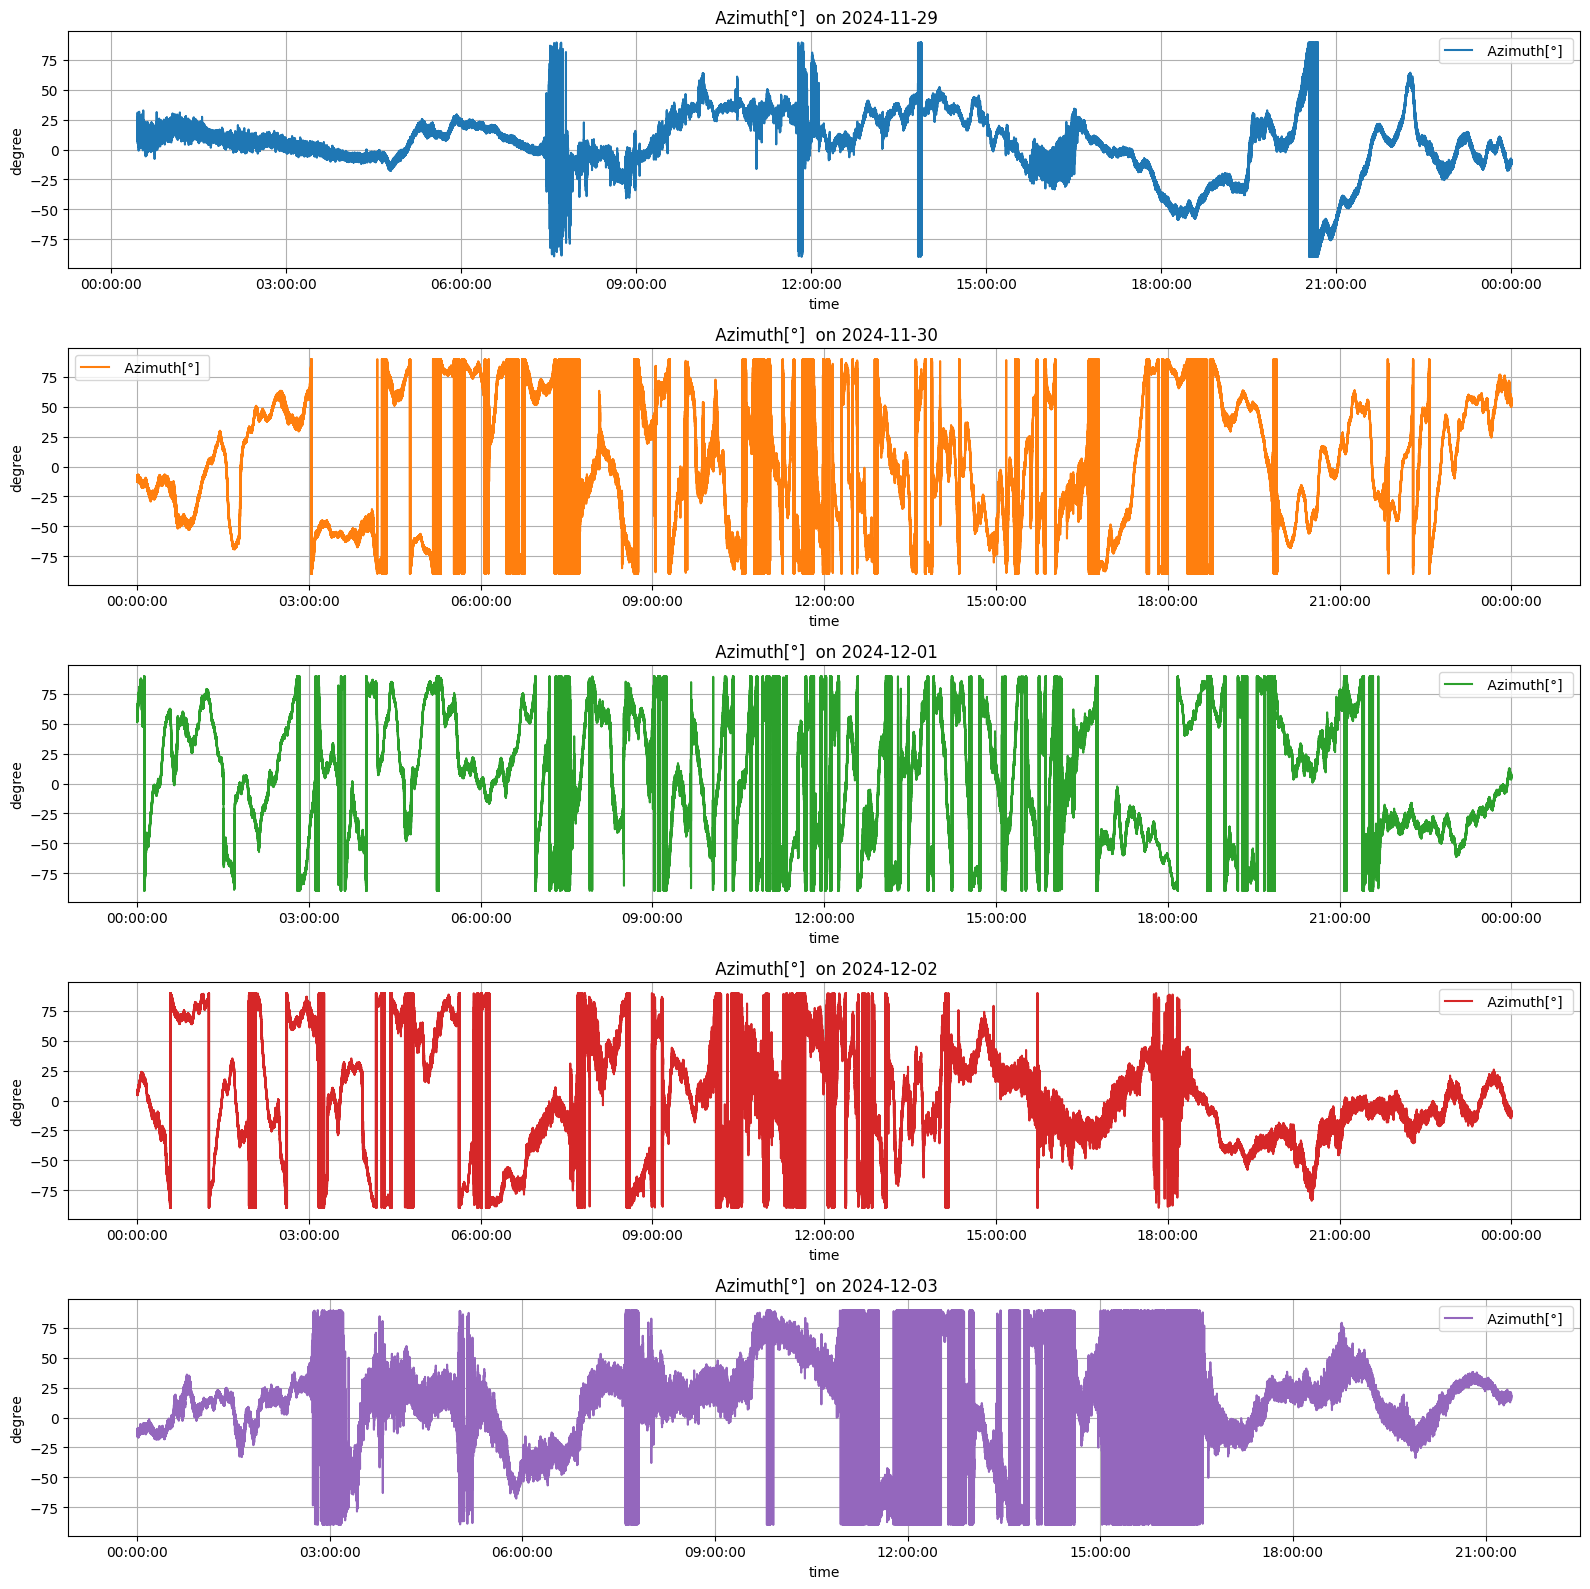

In [39]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(16, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[9]]

    ax.plot(df_day.index, df_day, label=columns[9], color=colors[i])
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[9]} on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

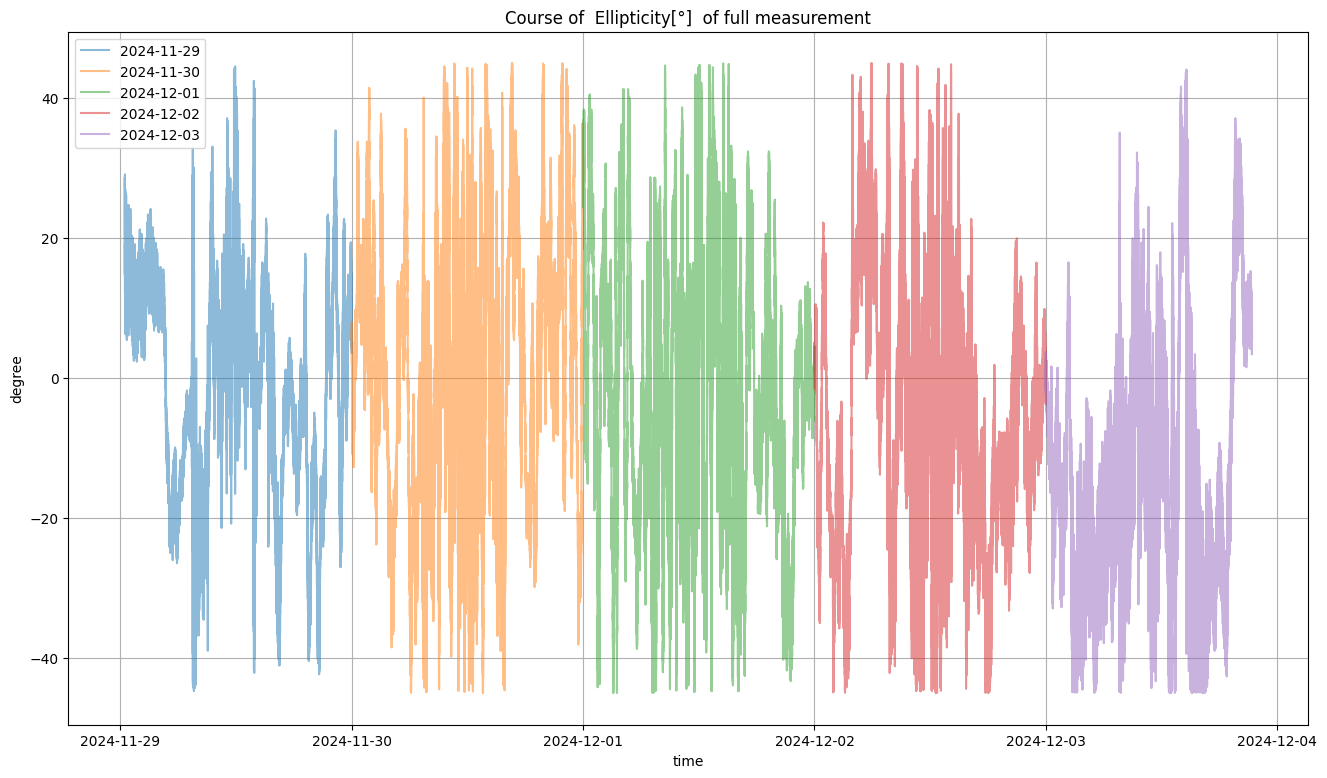

In [40]:
plt.figure(figsize = (16,9))
for date, df_day in angle_daily_list:
    values = df_day[columns[10]]
    plt.plot(values, label=str(date), alpha=0.5)
plt.grid()
plt.legend(loc = 'best')
plt.title(f'Course of {columns[10]} of full measurement')
plt.xlabel('time')
plt.ylabel('degree')
plt.show()

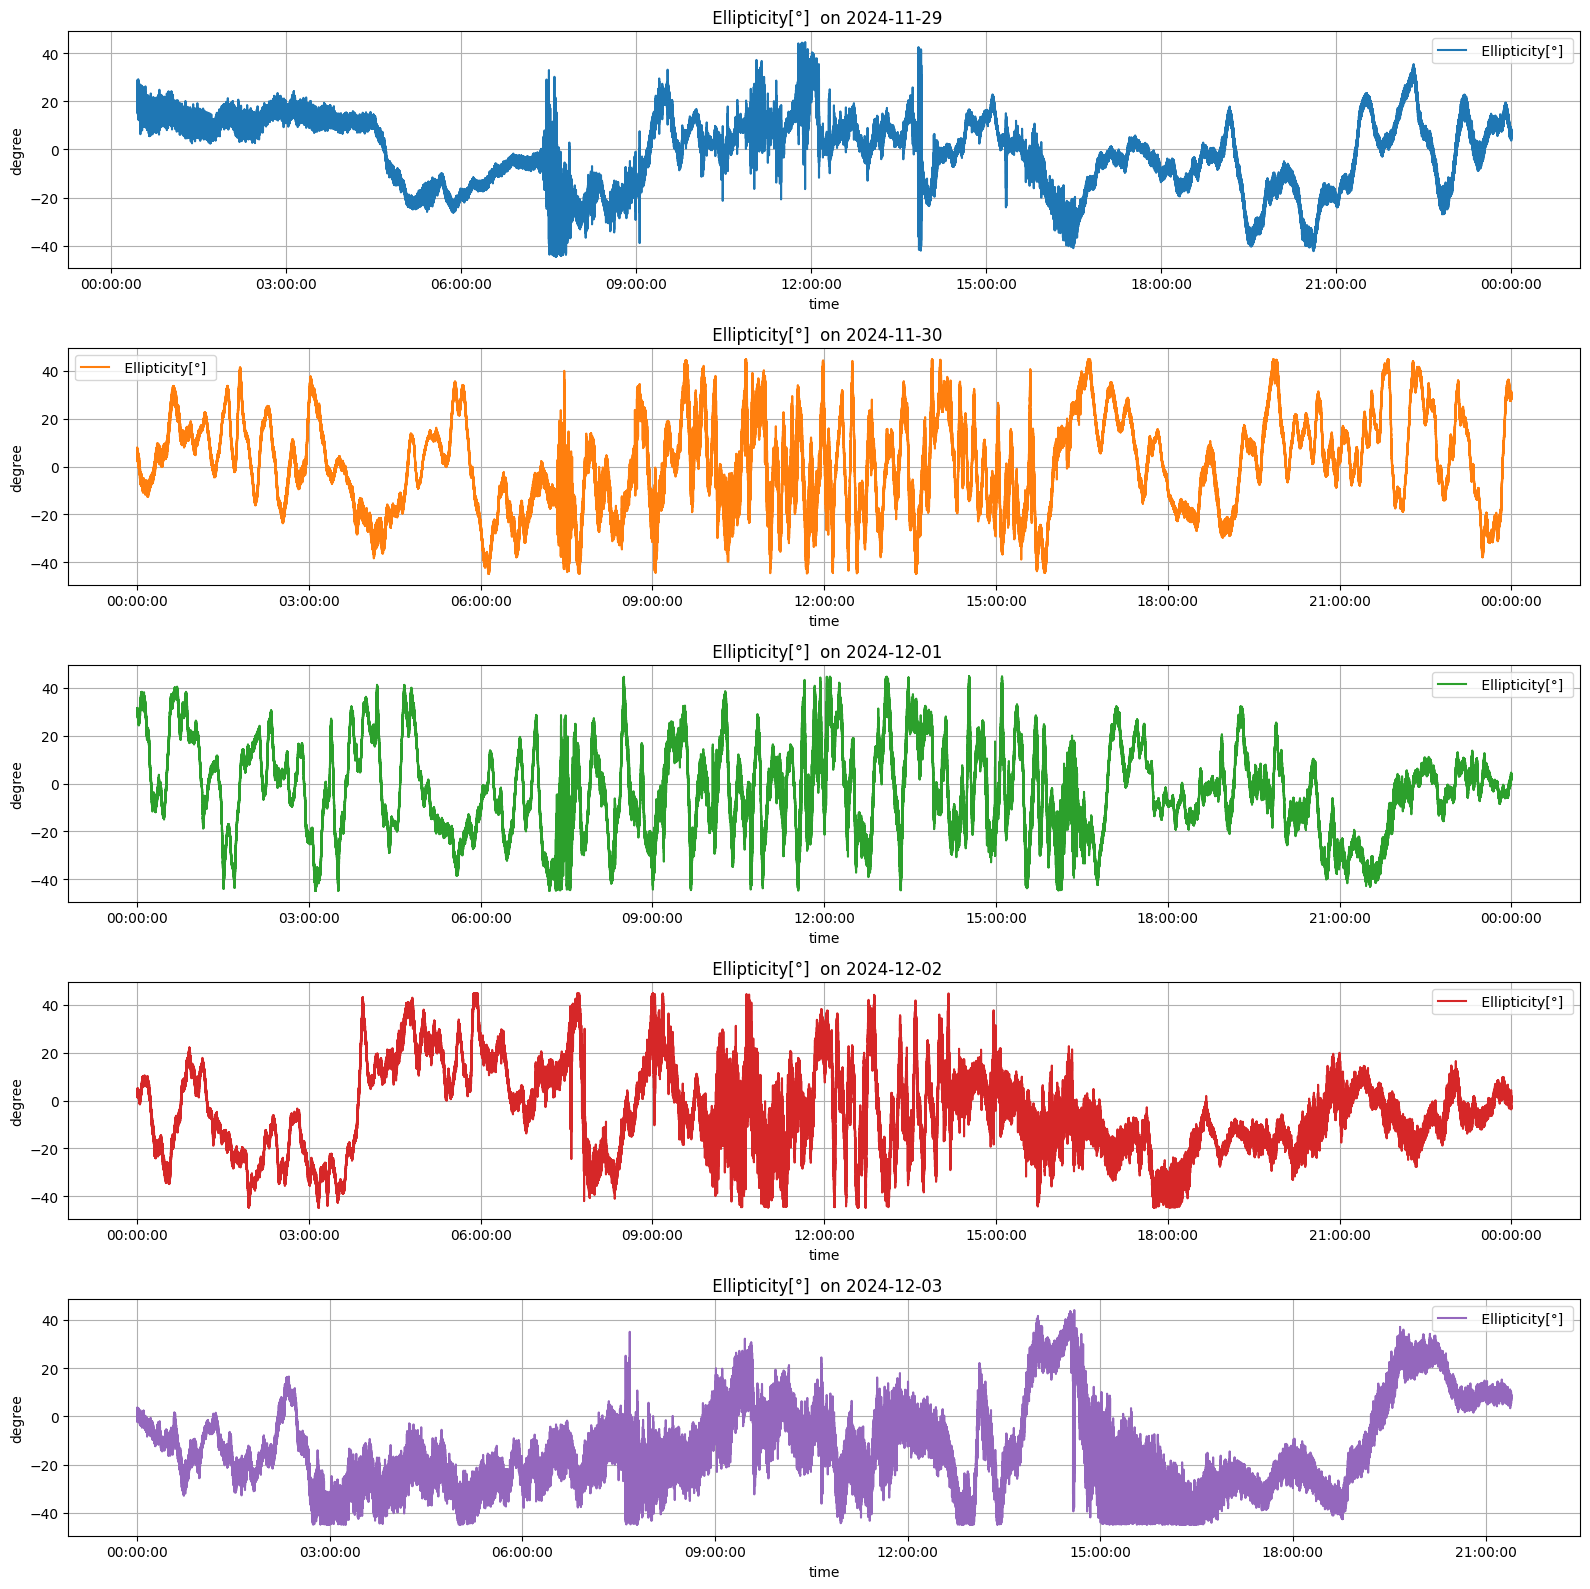

In [41]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(16, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    df_day = angle_daily_list[i][1][columns[10]]

    ax.plot(df_day.index, df_day, label=columns[10], color=colors[i])
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[10]} on {angle_daily_list[i][0]}')
    ax.set_xlabel('time')
    ax.set_ylabel('degree')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

plt.tight_layout()
plt.show()

## Tägliche Normalverteilung mit Histogramm

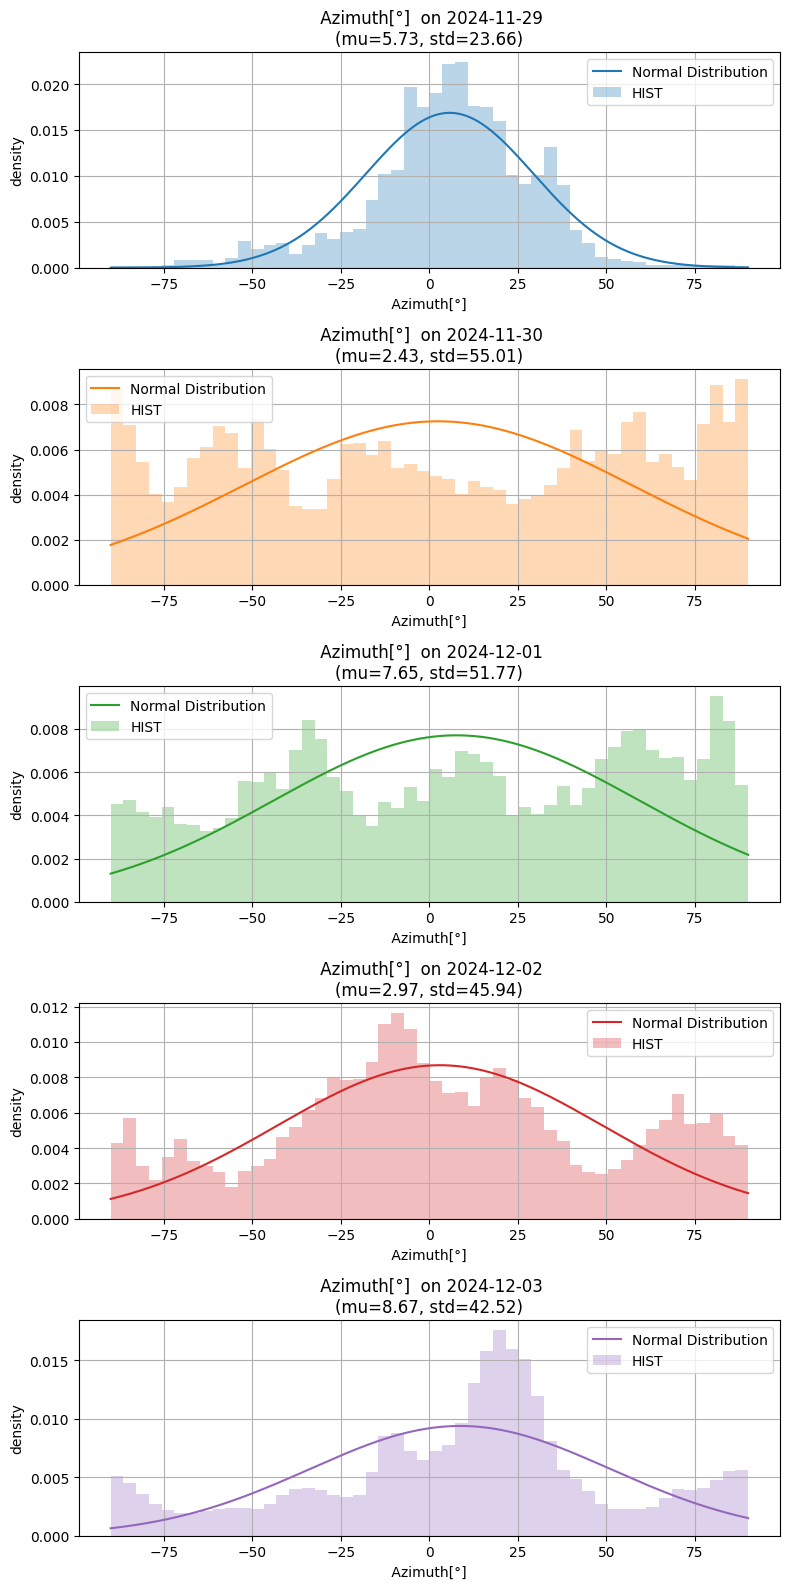

In [42]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    ydata1 = np.array(angle_daily_list[i][1][columns[9]])
    mu1 = np.mean(ydata1)
    sigma1 = np.std(ydata1)
    x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
    y1 = norm.pdf(x1, mu1, sigma1)  

    ax.plot(x1, y1, label = 'Normal Distribution', color=colors[i])
    ax.hist(ydata1, bins = 50, density = True, color=colors[i], alpha = 0.3, label = "HIST")
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[9]} on {angle_daily_list[i][0]}\n(mu={mu1:.2f}, std={sigma1:.2f})')
    ax.set_xlabel(columns[9])
    ax.set_ylabel('density')

plt.tight_layout()
plt.show()

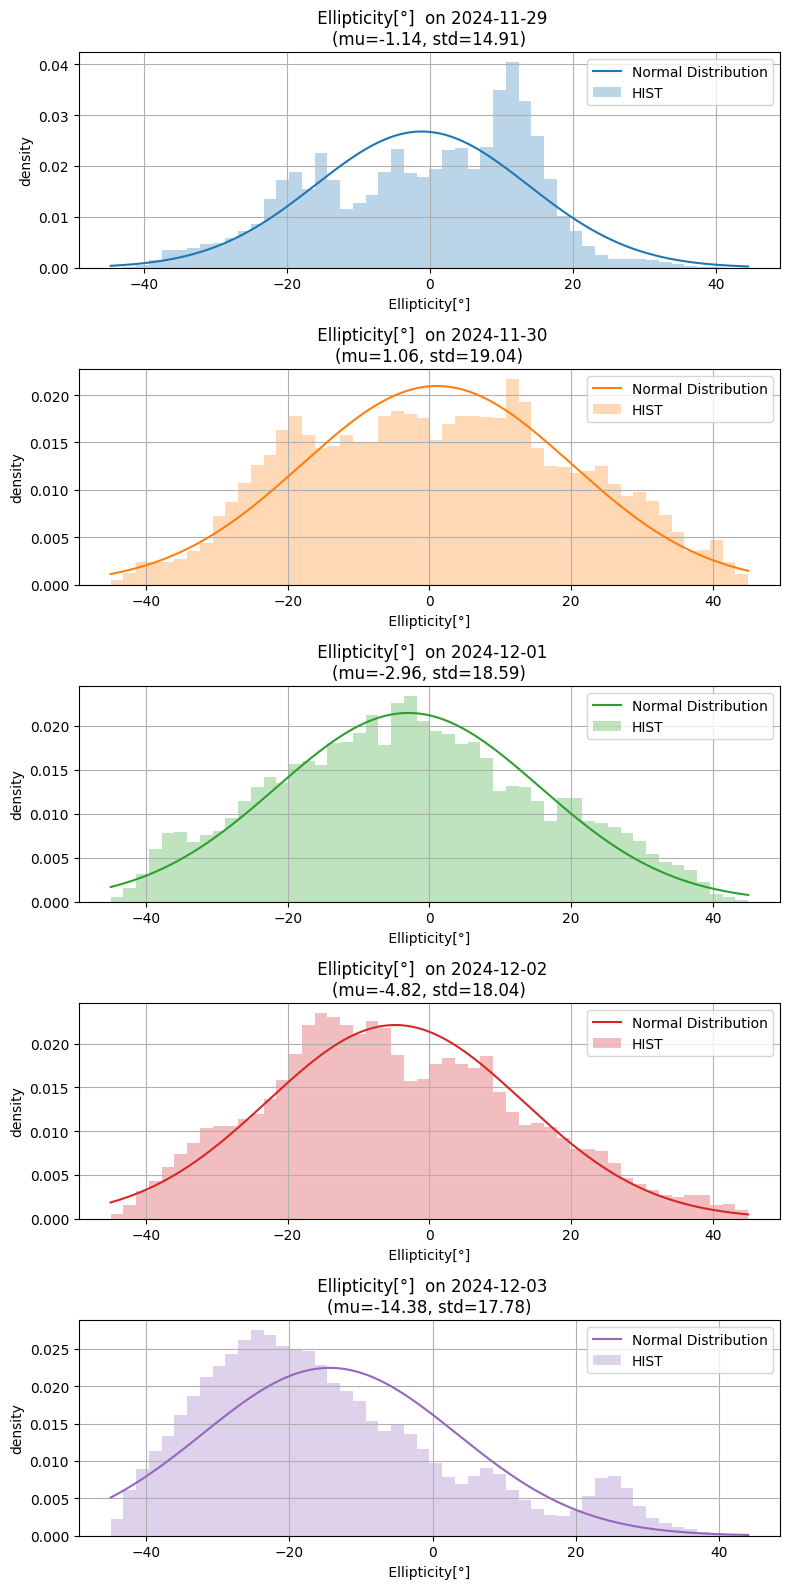

In [43]:
fig, axs = plt.subplots(len(angle_daily_list), 1, figsize=(8, 16), sharex=False)

for i in range(len(angle_daily_list)):
    ax = axs[i] if len(angle_daily_list) > 1 else axs
    ydata1 = np.array(angle_daily_list[i][1][columns[10]])
    mu1 = np.mean(ydata1)
    sigma1 = np.std(ydata1)
    x1 = np.linspace(ydata1.min(),ydata1.max(),len(ydata1))
    y1 = norm.pdf(x1, mu1, sigma1)  

    ax.plot(x1, y1, label = 'Normal Distribution', color=colors[i])
    ax.hist(ydata1, bins = 50, density = True, color=colors[i], alpha = 0.3, label = "HIST")
    
    ax.grid()
    ax.legend(loc='best')
    ax.set_title(f'{columns[10]} on {angle_daily_list[i][0]}\n(mu={mu1:.2f}, std={sigma1:.2f})')
    ax.set_xlabel(columns[10])
    ax.set_ylabel('density')

plt.tight_layout()
plt.show()

## Filterung mittels Tief- und Hochpass

#### Azimuth

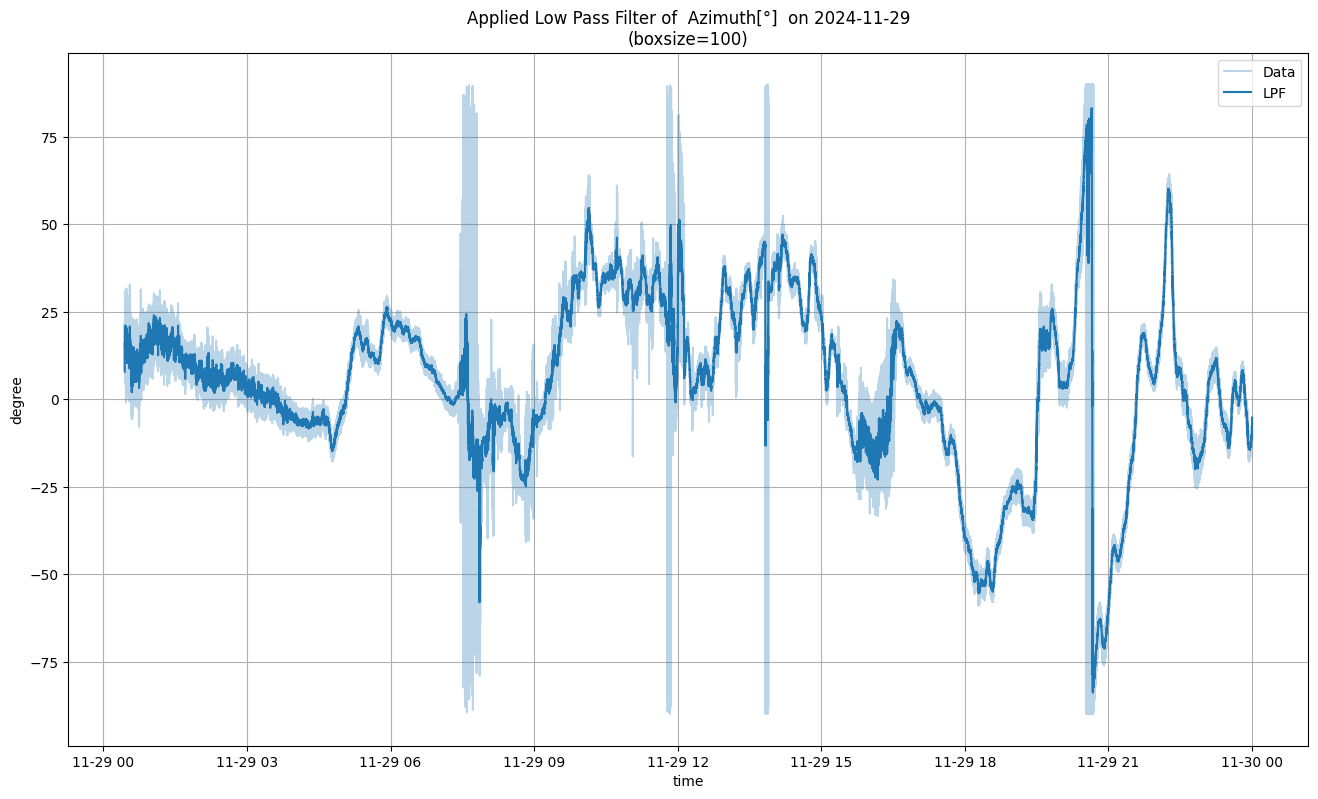

In [45]:
box = 100

time = angle_daily_list[day][1].index
ydata = np.array(angle_daily_list[day][1][columns[9]])
lps = lowpass(ydata, box)

plt.figure(figsize = (16,9))
plt.plot(time, ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(time, lps[:-1], label = 'LPF', color = colors[day])
plt.title(f'Applied Low Pass Filter of {columns[9]} on {angle_daily_list[day][0]}\n(boxsize={box})')
plt.xlabel('time')
plt.ylabel('degree')
plt.grid()
plt.legend(loc = 'best')
plt.show()

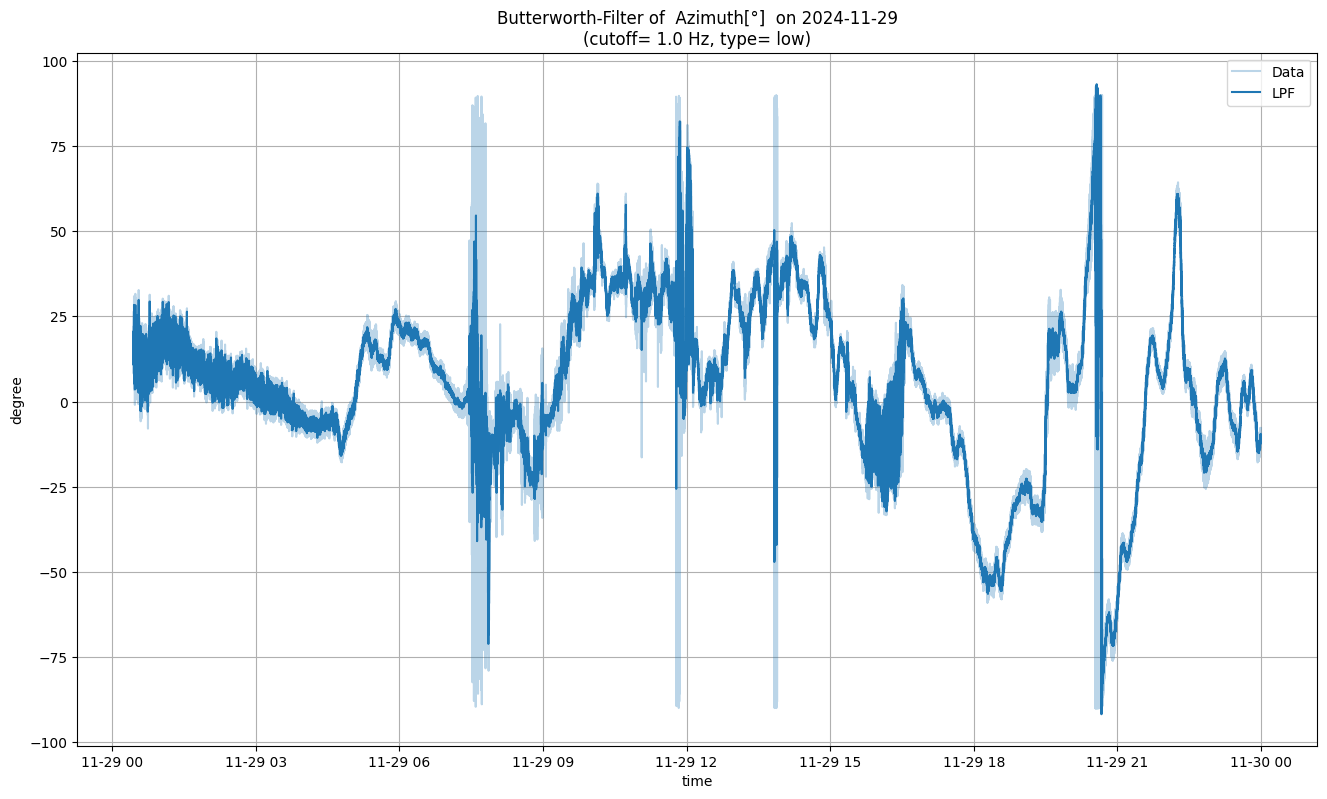

In [46]:
cutoff = 1.0
btype='low'

time = angle_daily_list[day][1].index
ydata = np.array(angle_daily_list[day][1][columns[9]])
lps = butter_filter(ydata, cutoff = cutoff, btype=btype)

plt.figure(figsize = (16,9))
plt.plot(time, ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(time, lps, label = 'LPF', color = colors[day])
plt.title(f'Butterworth-Filter of {columns[9]} on {angle_daily_list[day][0]}\n(cutoff= {cutoff} Hz, type= {btype})')
plt.xlabel('time')
plt.ylabel('degree')
plt.grid()
plt.legend(loc = 'best')
plt.show()

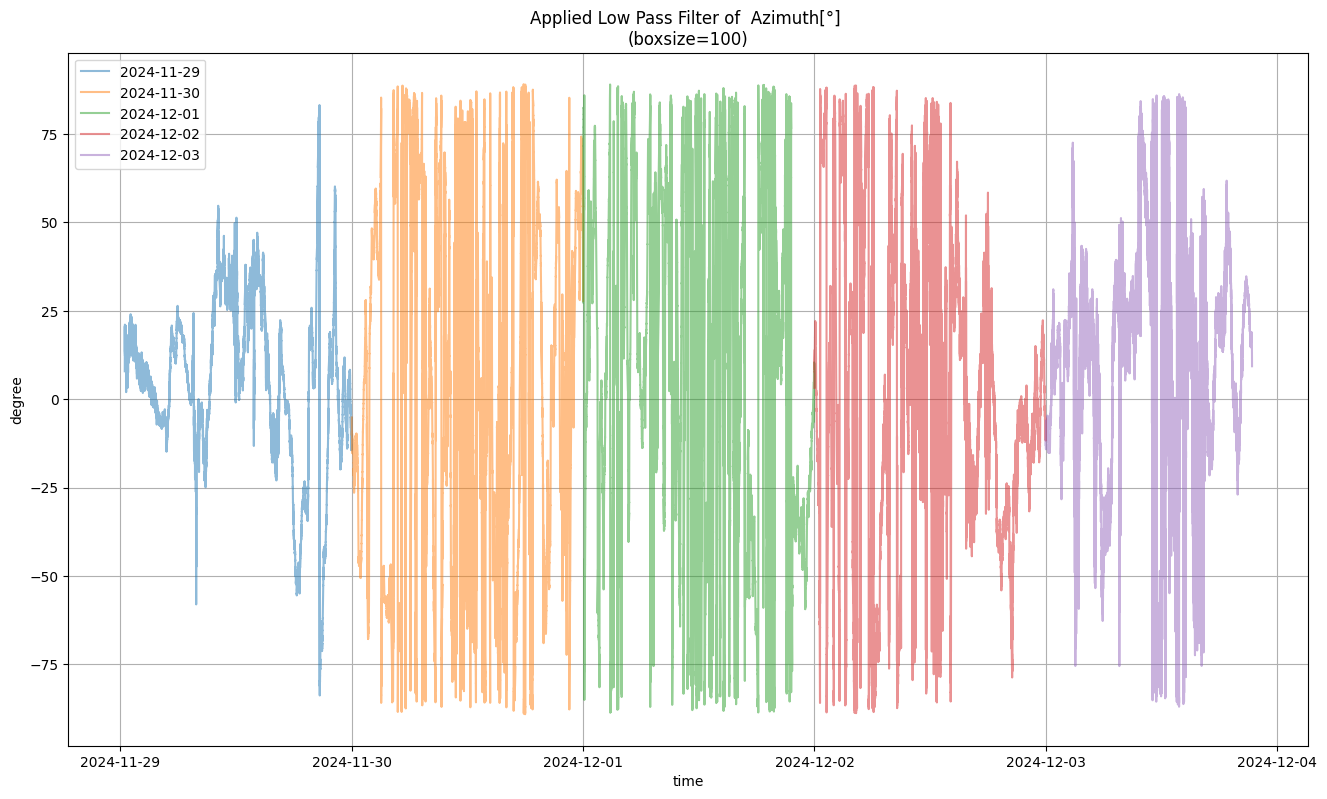

In [53]:
box = 100

plt.figure(figsize = (16,9))
for date, df_day in angle_daily_list:
    ydata = np.array(df_day[columns[9]])
    lps = lowpass(ydata, box)
    plt.plot(df_day.index, lps[:-1], label=str(date) , alpha=0.5)

plt.legend(loc = 'best')
plt.title(f'Applied Low Pass Filter of {columns[9]}\n(boxsize={box})')
plt.xlabel('time')
plt.ylabel('degree')
plt.grid()
plt.show()

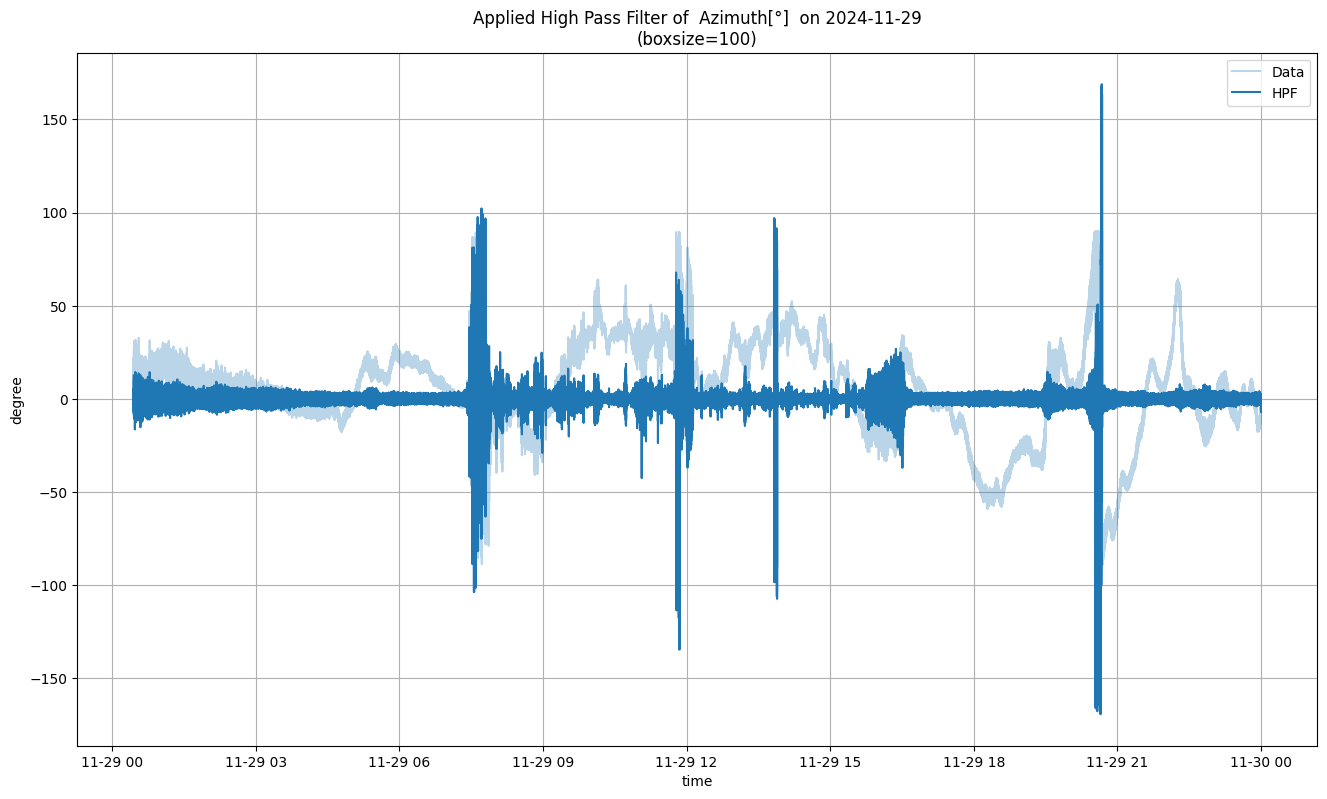

In [47]:
box = 100

time = angle_daily_list[day][1].index
ydata = np.array(angle_daily_list[day][1][columns[9]])
hps = highpass(ydata, box)

plt.figure(figsize = (16,9))
plt.plot(time, ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(time, hps, label = 'HPF', color = colors[day])
plt.title(f'Applied High Pass Filter of {columns[9]} on {angle_daily_list[day][0]}\n(boxsize={box})')
plt.xlabel('time')
plt.ylabel('degree')
plt.grid()
plt.legend(loc = 'best')
plt.show()

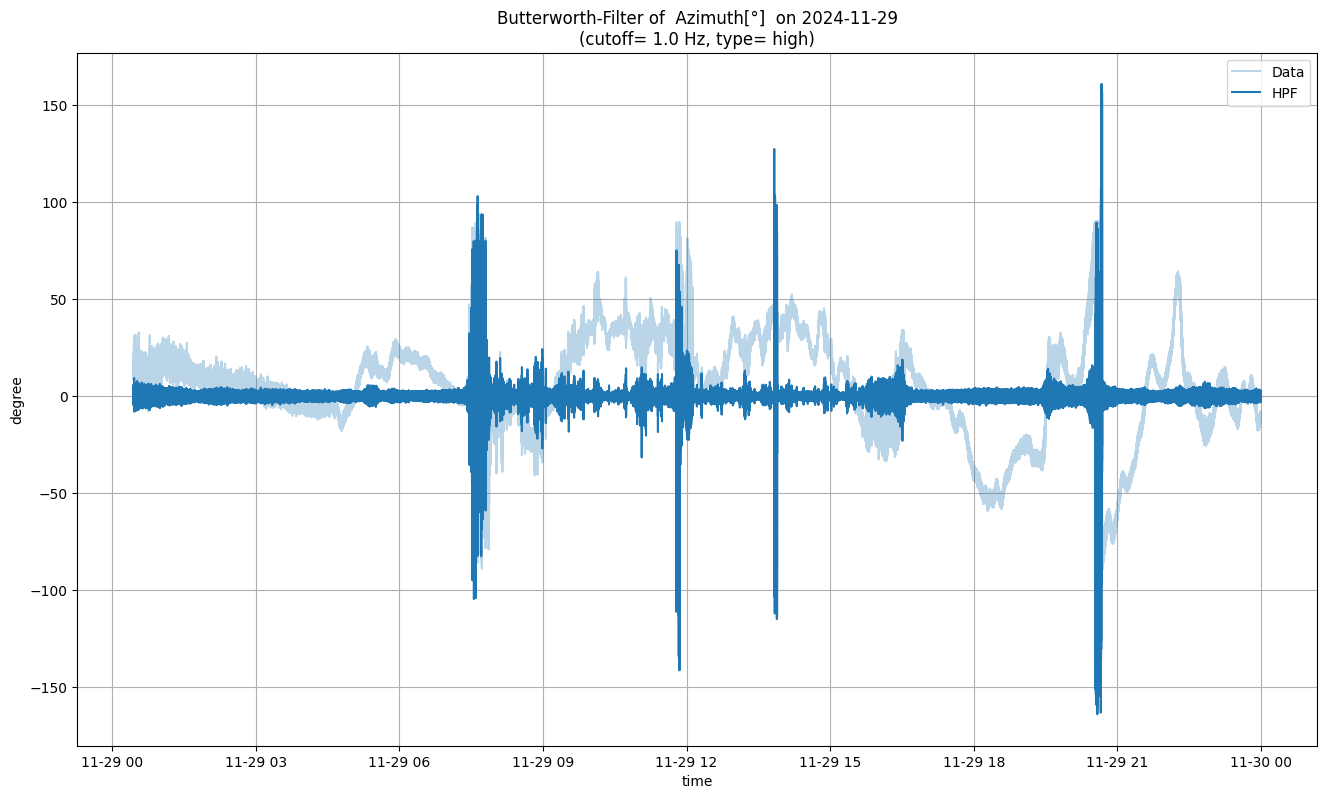

In [48]:
cutoff = 1.0
btype='high'

time = angle_daily_list[day][1].index
ydata = np.array(angle_daily_list[day][1][columns[9]])
hps = butter_filter(ydata, cutoff = cutoff, btype=btype)

plt.figure(figsize = (16,9))
plt.plot(time, ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(time, hps, label = 'HPF', color = colors[day])
plt.title(f'Butterworth-Filter of {columns[9]} on {angle_daily_list[day][0]}\n(cutoff= {cutoff} Hz, type= {btype})')
plt.xlabel('time')
plt.ylabel('degree')
plt.grid()
plt.legend(loc = 'best')
plt.show()

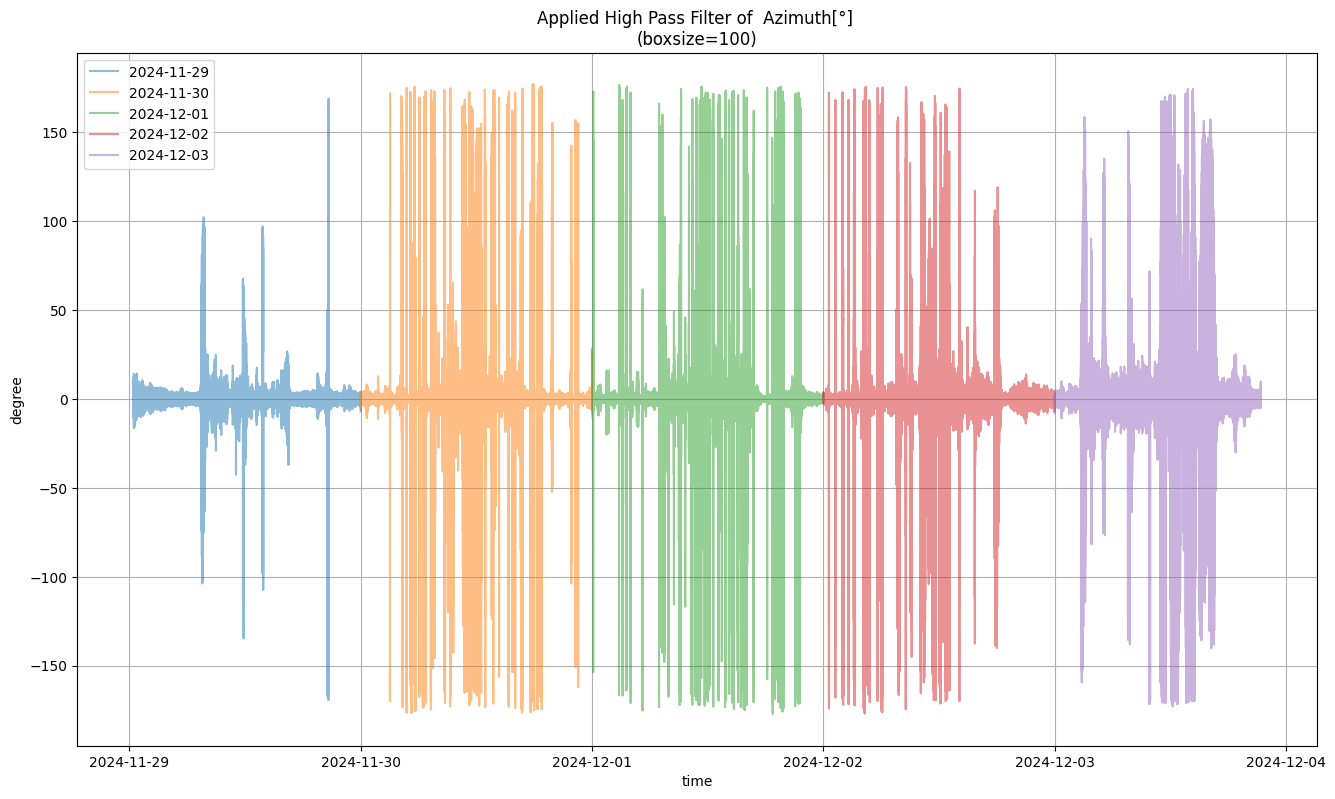

In [54]:
box = 100

plt.figure(figsize = (16,9))
for date, df_day in angle_daily_list:
    ydata = np.array(df_day[columns[9]])
    hps = highpass(ydata, box)
    plt.plot(df_day.index, hps, label=str(date) , alpha=0.5)

plt.legend(loc = 'best')
plt.title(f'Applied High Pass Filter of {columns[9]}\n(boxsize={box})')
plt.xlabel('time')
plt.ylabel('degree')
plt.grid()
plt.show()

#### Ellipticity

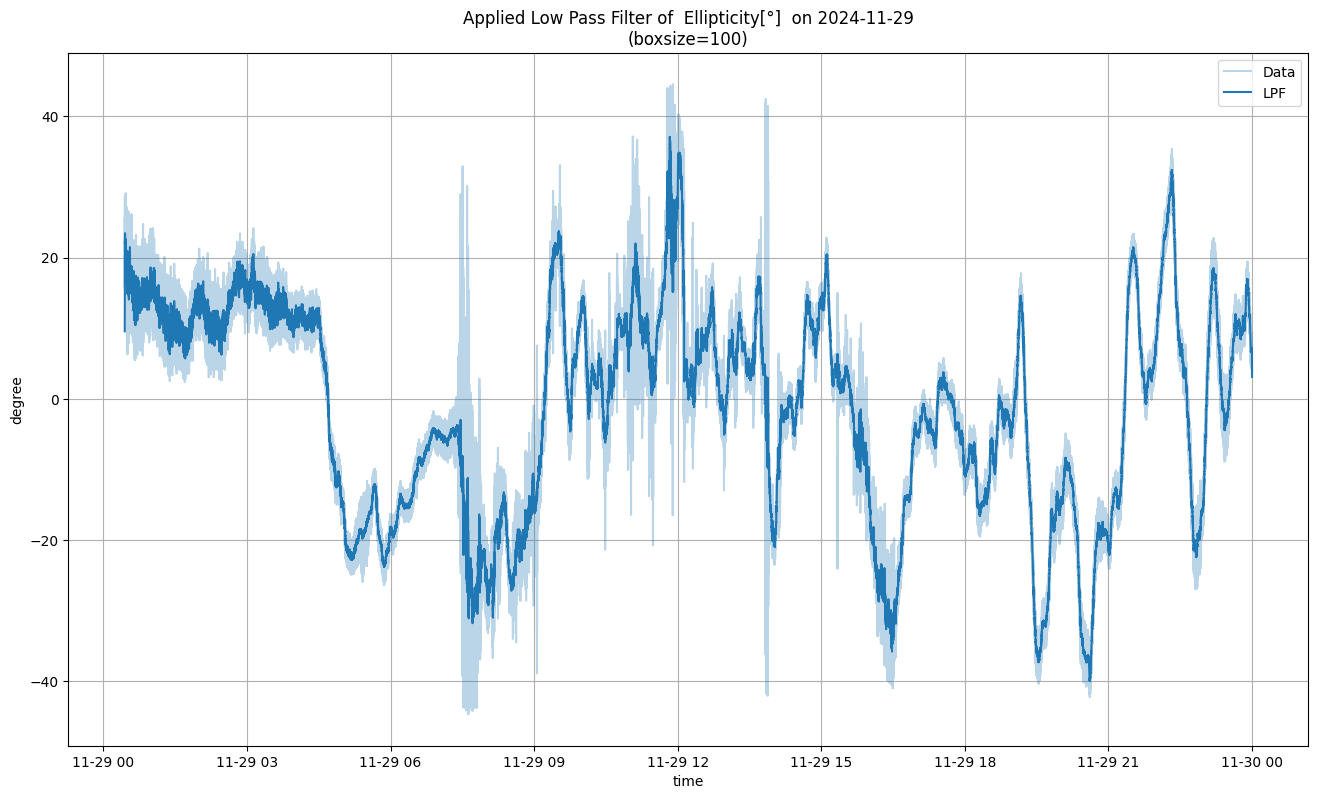

In [49]:
box = 100

time = angle_daily_list[day][1].index
ydata = np.array(angle_daily_list[day][1][columns[10]])
lps = lowpass(ydata, box)

plt.figure(figsize = (16,9))
plt.plot(time, ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(time, lps[:-1], label = 'LPF', color = colors[day])
plt.title(f'Applied Low Pass Filter of {columns[10]} on {angle_daily_list[day][0]}\n(boxsize={box})')
plt.xlabel('time')
plt.ylabel('degree')
plt.grid()
plt.legend(loc = 'best')
plt.show()

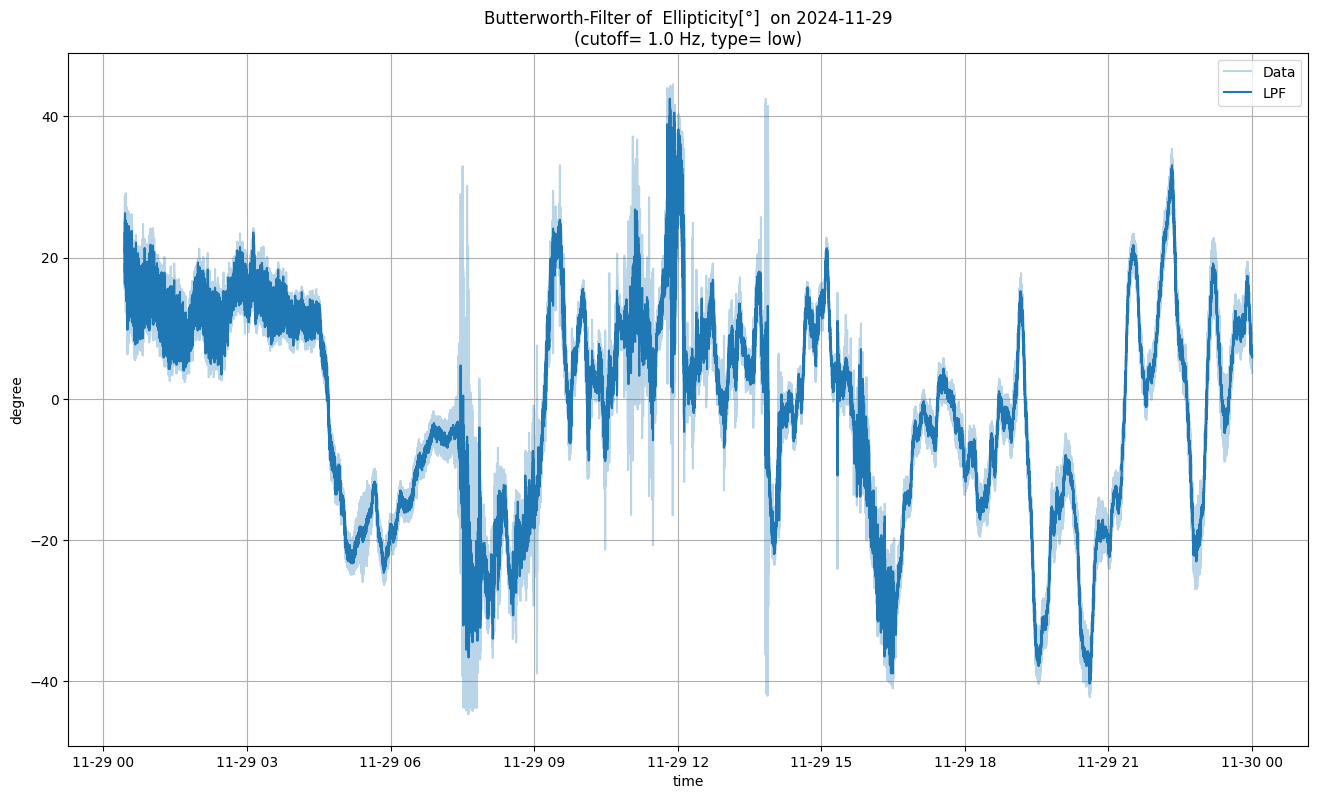

In [50]:
cutoff = 1.0
btype='low'

time = angle_daily_list[day][1].index
ydata = np.array(angle_daily_list[day][1][columns[10]])
lps = butter_filter(ydata, cutoff = cutoff, btype=btype)

plt.figure(figsize = (16,9))
plt.plot(time, ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(time, lps, label = 'LPF', color = colors[day])
plt.title(f'Butterworth-Filter of {columns[10]} on {angle_daily_list[day][0]}\n(cutoff= {cutoff} Hz, type= {btype})')
plt.xlabel('time')
plt.ylabel('degree')
plt.grid()
plt.legend(loc = 'best')
plt.show()

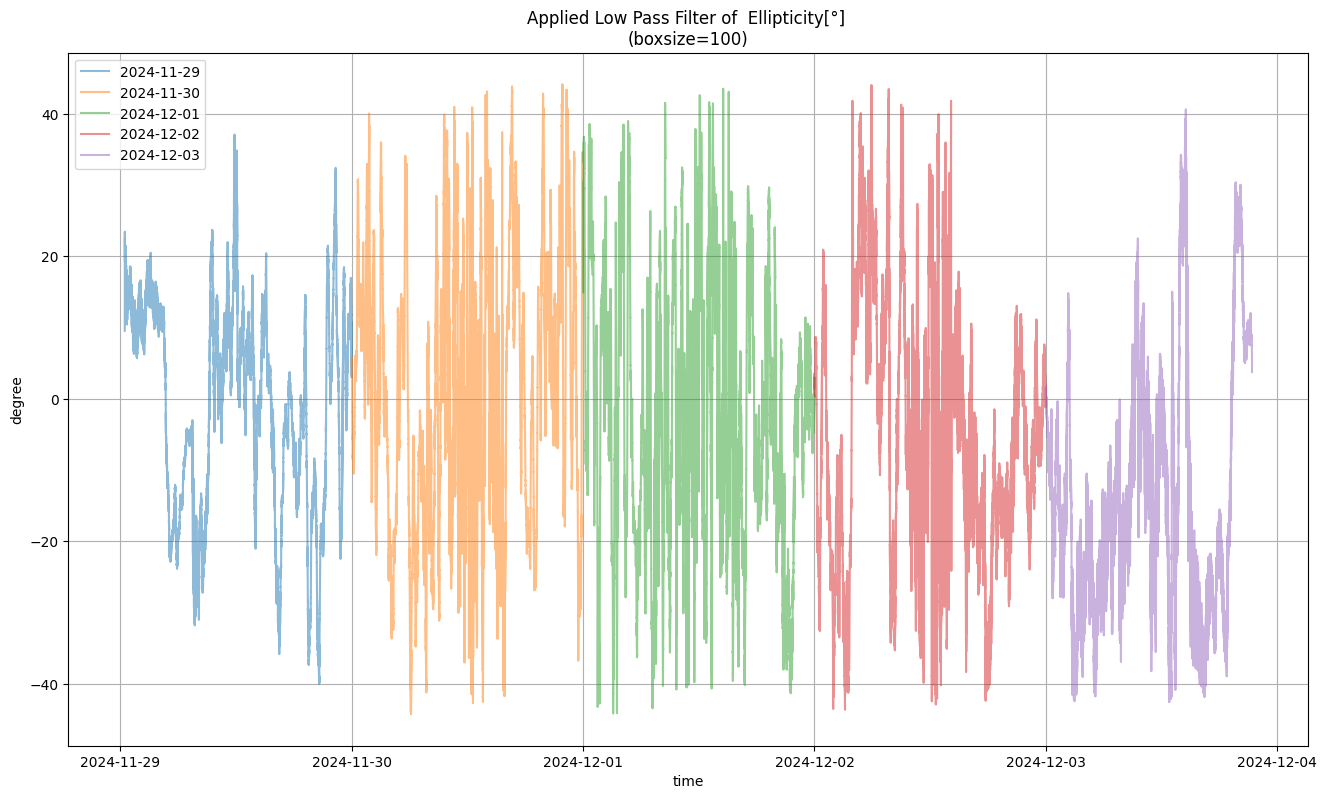

In [55]:
box = 100

plt.figure(figsize = (16,9))
for date, df_day in angle_daily_list:
    ydata = np.array(df_day[columns[10]])
    lps = lowpass(ydata, box)
    plt.plot(df_day.index, lps[:-1], label=str(date) , alpha=0.5)

plt.legend(loc = 'best')
plt.title(f'Applied Low Pass Filter of {columns[10]}\n(boxsize={box})')
plt.xlabel('time')
plt.ylabel('degree')
plt.grid()
plt.show()

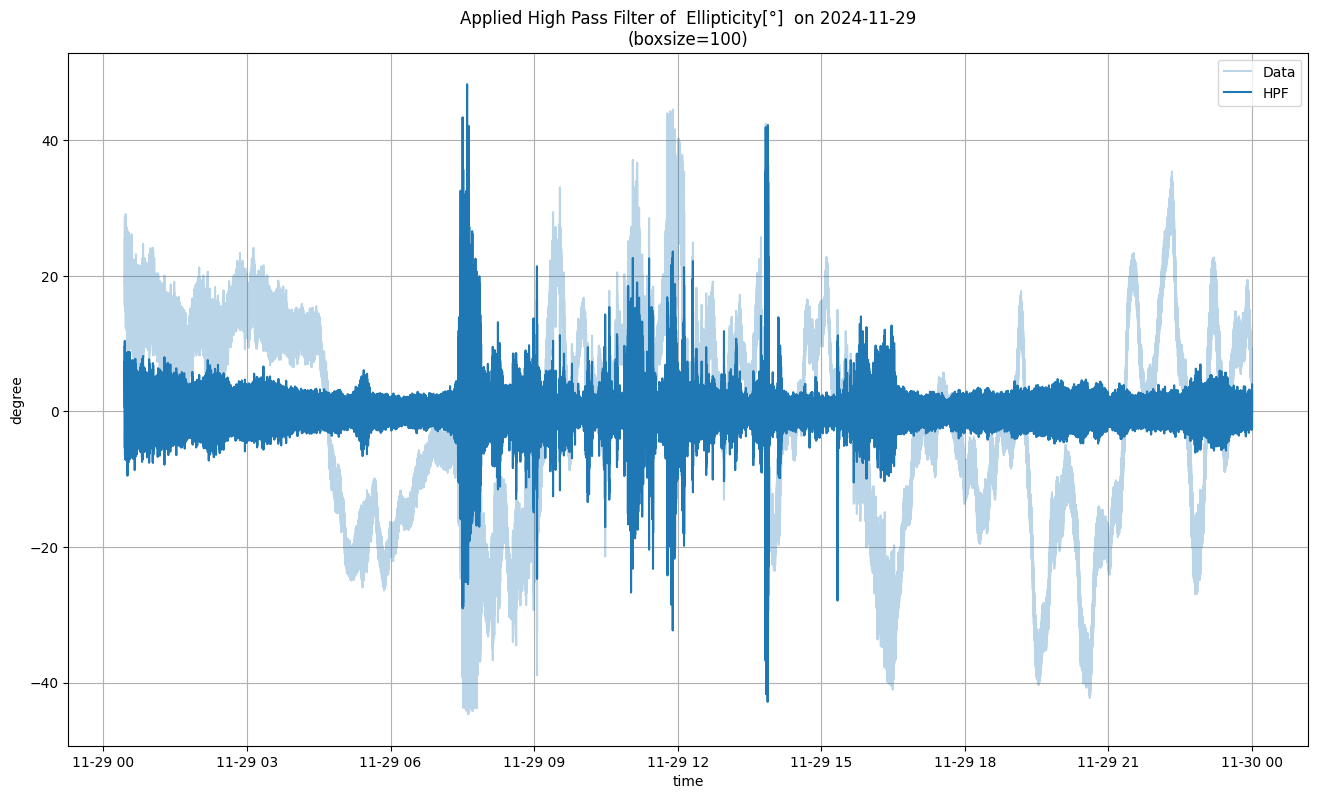

In [51]:
box = 100

time = angle_daily_list[day][1].index
ydata = np.array(angle_daily_list[day][1][columns[10]])
hps = highpass(ydata, box)

plt.figure(figsize = (16,9))
plt.plot(time, ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(time, hps, label = 'HPF', color = colors[day])
plt.title(f'Applied High Pass Filter of {columns[10]} on {angle_daily_list[day][0]}\n(boxsize={box})')
plt.xlabel('time')
plt.ylabel('degree')
plt.grid()
plt.legend(loc = 'best')
plt.show()

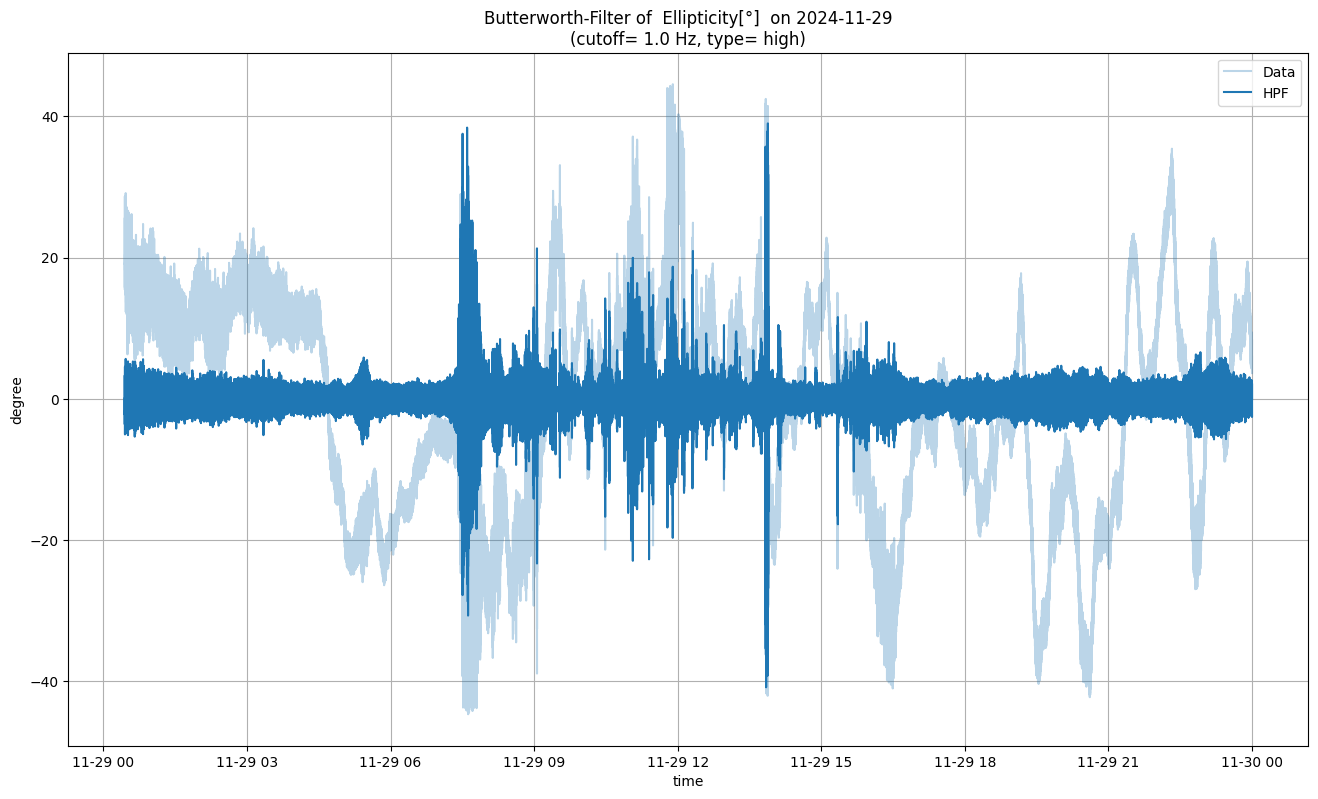

In [52]:
cutoff = 1.0
btype='high'

time = angle_daily_list[day][1].index
ydata = np.array(angle_daily_list[day][1][columns[10]])
hps = butter_filter(ydata, cutoff = cutoff, btype=btype)

plt.figure(figsize = (16,9))
plt.plot(time, ydata, label = 'Data', color = colors[day], alpha=0.3)
plt.plot(time, hps, label = 'HPF', color = colors[day])
plt.title(f'Butterworth-Filter of {columns[10]} on {angle_daily_list[day][0]}\n(cutoff= {cutoff} Hz, type= {btype})')
plt.xlabel('time')
plt.ylabel('degree')
plt.grid()
plt.legend(loc = 'best')
plt.show()

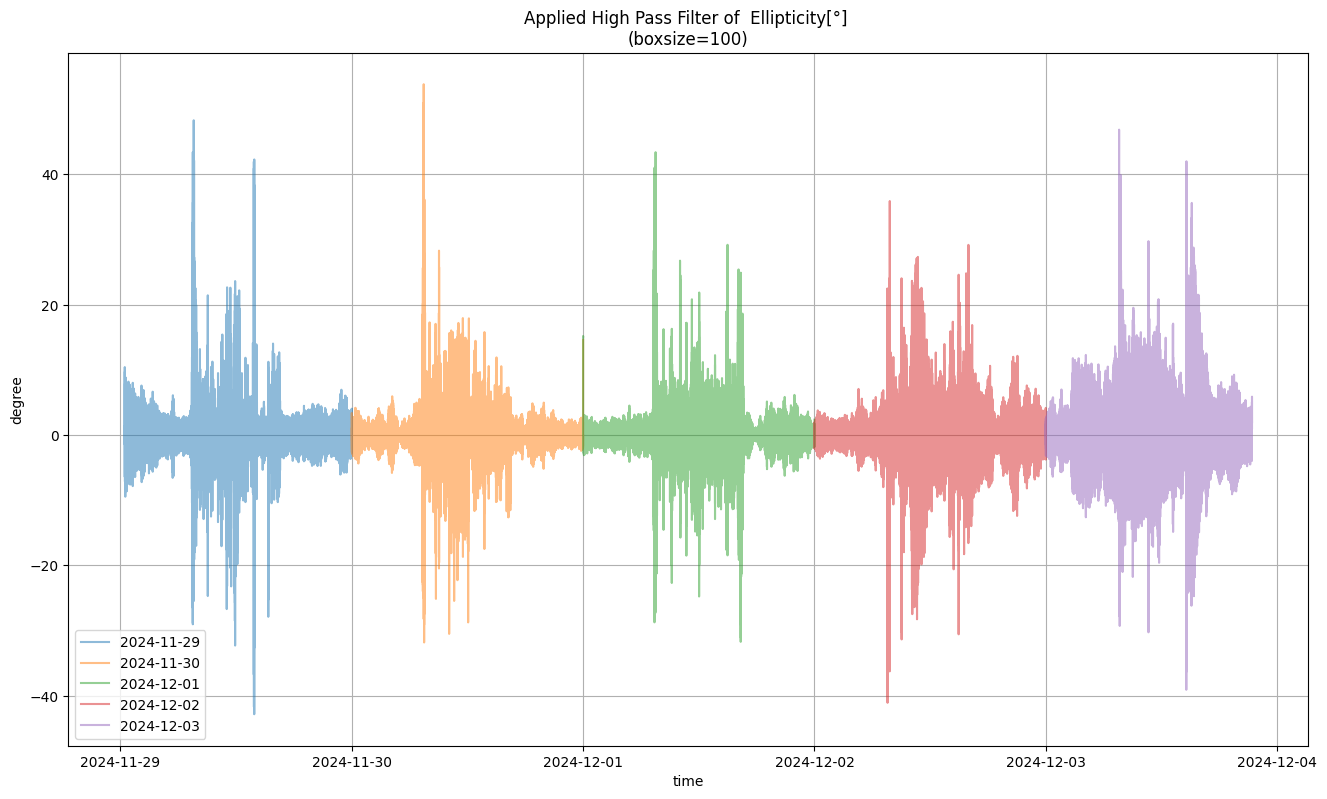

In [56]:
box = 100

plt.figure(figsize = (16,9))
for date, df_day in angle_daily_list:
    ydata = np.array(df_day[columns[10]])
    hps = highpass(ydata, box)
    plt.plot(df_day.index, hps, label=str(date) , alpha=0.5)

plt.legend(loc = 'best')
plt.title(f'Applied High Pass Filter of {columns[10]}\n(boxsize={box})')
plt.xlabel('time')
plt.ylabel('degree')
plt.grid()
plt.show()

## Darstellung auf der Poincaré-Kugel
### Visualisierung mit dem Python-Tool [„py_pol“](https://py-pol.readthedocs.io/en/master/index.html)

In [57]:
one_second = datetime.timedelta(seconds=1)
one_minute = datetime.timedelta(minutes=1)
one_hour = datetime.timedelta(hours=1)
one_quater = datetime.timedelta(hours=6)
one_half = datetime.timedelta(hours=12)
one_day = datetime.timedelta(days=1)

start_time = datetime.datetime.strptime(str(angle.index[0]), '%Y-%m-%d %H:%M:%S.%f')
end_time_second = start_time + one_second
end_time_minute = start_time + one_minute
end_time_hour = start_time + one_hour
end_time_quater = start_time + one_quater
end_time_half = start_time + one_half
end_time_day = start_time + one_day

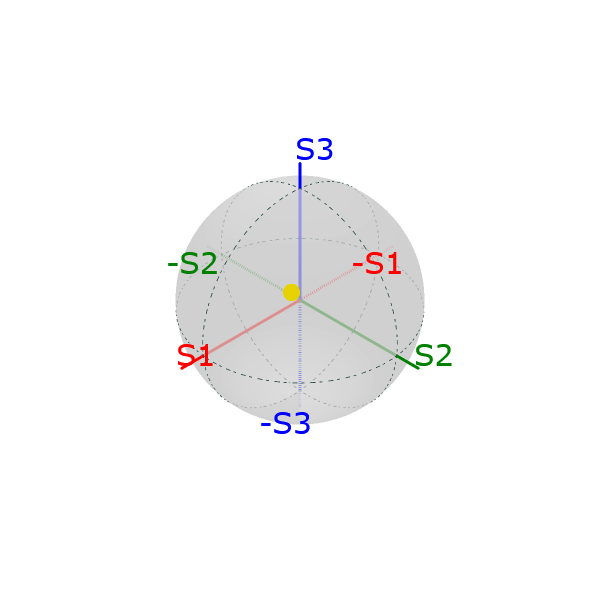

In [58]:
first_val = angle.iloc[0]

az = np.array(first_val[columns[9]]) * degrees
el = np.array(first_val[columns[10]]) * degrees

S = Stokes("Calculated Point")
S.general_azimuth_ellipticity(az, el)

fig = S.draw_poincare(kind="scatter")
#fig.show()
Image(filename="./img/first_val.png")

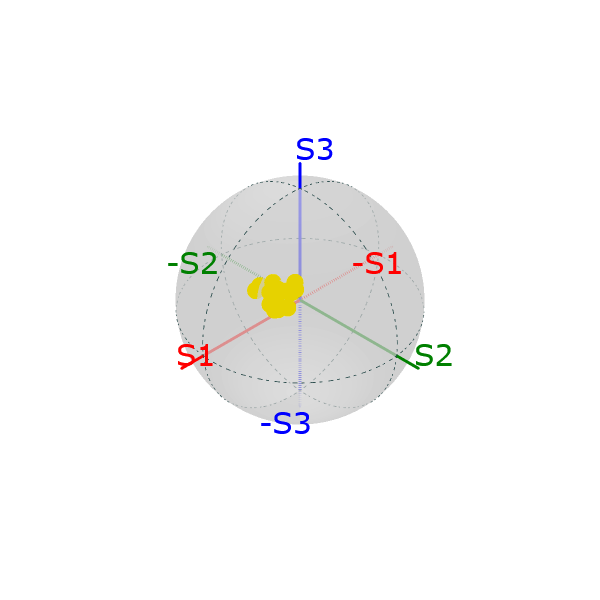

In [59]:
first_second = angle.loc[(angle.index >= start_time) & (angle.index < end_time_second)]

az = np.array(first_second[columns[9]].values) * degrees  
el = np.array(first_second[columns[10]].values) * degrees

S = Stokes("Calculated Points")
S.general_azimuth_ellipticity(az, el)

fig = S.draw_poincare(kind="scatter")
#fig.show()
Image(filename="./img/first_second.png")

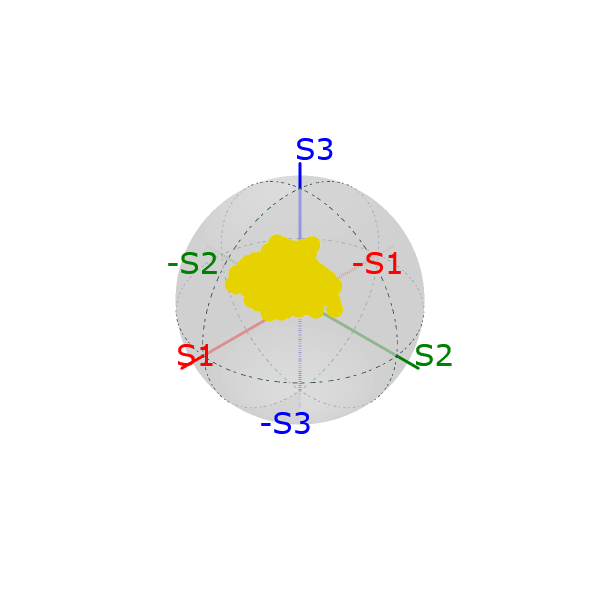

In [60]:
first_minute = angle.loc[(angle.index >= start_time) & (angle.index < end_time_minute)]

az = np.array(first_minute[columns[9]].values) * degrees
el = np.array(first_minute[columns[10]].values) * degrees

S = Stokes("Calculated Points")
S.general_azimuth_ellipticity(az, el)

fig = S.draw_poincare(kind="scatter")
#fig.show()
Image(filename="./img/first_minute.png")

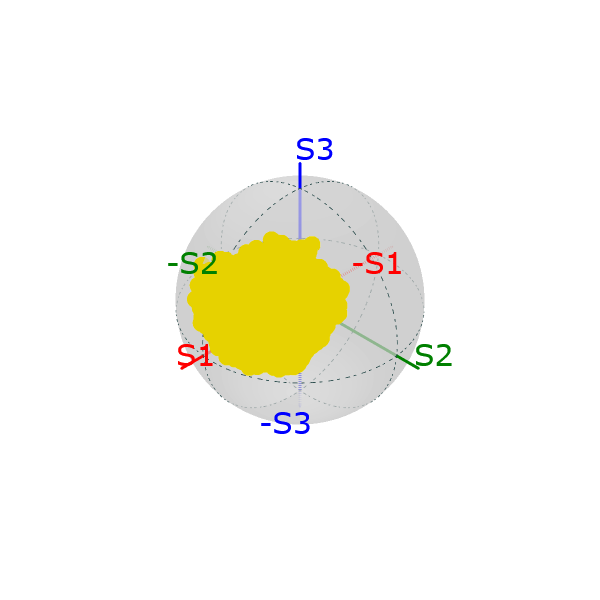

In [61]:
first_hour = angle.loc[(angle.index >= start_time) & (angle.index < end_time_hour)]

az = np.array(first_hour[columns[9]].values) * degrees
el = np.array(first_hour[columns[10]].values) * degrees

S = Stokes("Calculated Points")
S.general_azimuth_ellipticity(az, el)

fig = S.draw_poincare(kind="scatter")
#fig.show()
Image(filename="./img/first_hour.png")

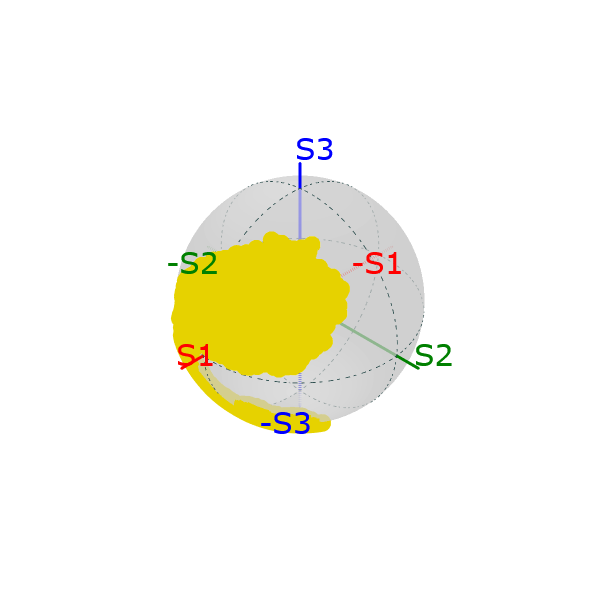

In [62]:
first_quater = angle.loc[(angle.index >= start_time) & (angle.index < end_time_quater)]

az = np.array(first_quater[columns[9]].values) * degrees
el = np.array(first_quater[columns[10]].values) * degrees

S = Stokes("Calculated Points")
S.general_azimuth_ellipticity(az, el)

fig = S.draw_poincare(kind="scatter")
#fig.show()
Image(filename="./img/first_quater.png")

### Eigene Berechnung und Visualisierung der Daten

In [63]:
normalized_stokes = pd.read_csv(filename,skiprows=skip, usecols=[columns[2], columns[3], columns[4]], sep=sep, nrows=19)
x,y,z = convert_angel(first_second[columns[9]].values, first_second[columns[10]].values)

data = pd.DataFrame({
    "S1": x,
    "Normalized S1": normalized_stokes[columns[2]],
    "S2": y,
    "Normalized S2": normalized_stokes[columns[3]],
    "S3": z,
    "Normalized S3": normalized_stokes[columns[4]]
})
print(data)

          S1  Normalized S1        S2  Normalized S2        S3  Normalized S3
0   0.596336           0.60  0.511483           0.51  0.618683           0.62
1   0.701573           0.70  0.488696           0.49  0.518624           0.52
2   0.700520           0.70  0.482535           0.48  0.525769           0.53
3   0.655133           0.66  0.534695           0.53  0.533762           0.53
4   0.646914           0.65  0.488193           0.49  0.585807           0.59
5   0.604898           0.60  0.497930           0.50  0.621421           0.62
6   0.550527           0.55  0.498488           0.50  0.669649           0.67
7   0.569661           0.57  0.523097           0.52  0.633921           0.63
8   0.613659           0.61  0.484291           0.48  0.623607           0.62
9   0.661133           0.66  0.472976           0.47  0.582407           0.58
10  0.720448           0.72  0.431179           0.43  0.543174           0.54
11  0.717083           0.72  0.469604           0.47  0.515038  

In [64]:
print("Original normalized S1 equals calculated S1? ", data['Normalized S1'].equals(round(data['S1'], 2)))
print("Original normalized S2 equals calculated S2? ", data['Normalized S2'].equals(round(data['S2'], 2)))
print("Original normalized S3 equals calculated S3? ", data['Normalized S3'].equals(round(data['S3'], 2)))

Original normalized S1 equals calculated S1?  True
Original normalized S2 equals calculated S2?  True
Original normalized S3 equals calculated S3?  True


In [65]:
#%matplotlib notebook # interaktiver Plot-Mode
#%matplotlib inline # statischer Plot-Mode

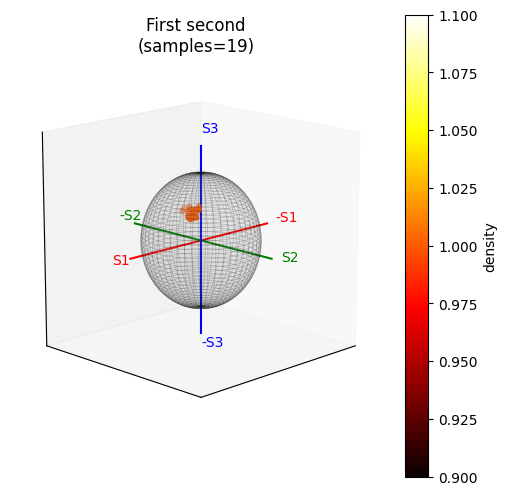

In [66]:
title = f'First second\n(samples={len(first_second)})'
x,y,z = convert_angel(first_second[columns[9]].values, first_second[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

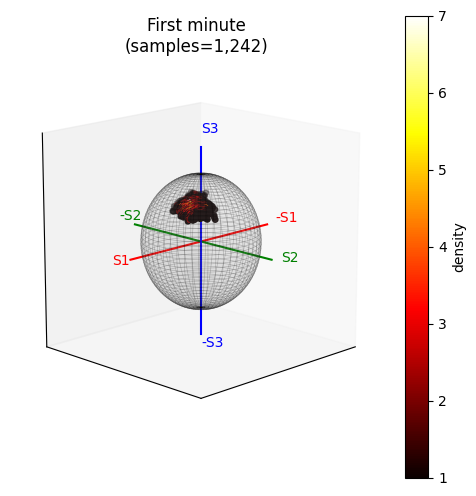

In [72]:
title = f'First minute\n(samples={len(first_minute):,})'
x,y,z = convert_angel(first_minute[columns[9]].values, first_minute[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

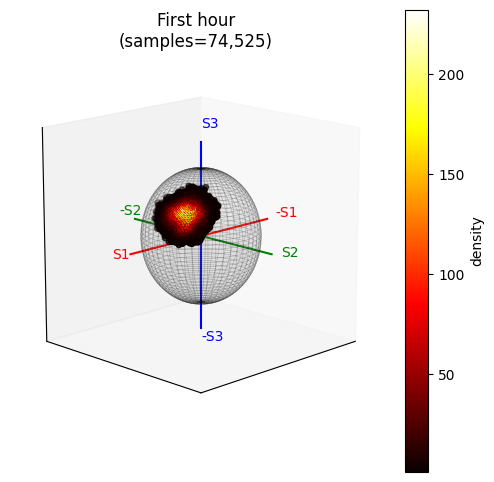

In [73]:
title = f'First hour\n(samples={len(first_hour):,})'
x,y,z = convert_angel(first_hour[columns[9]].values, first_hour[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

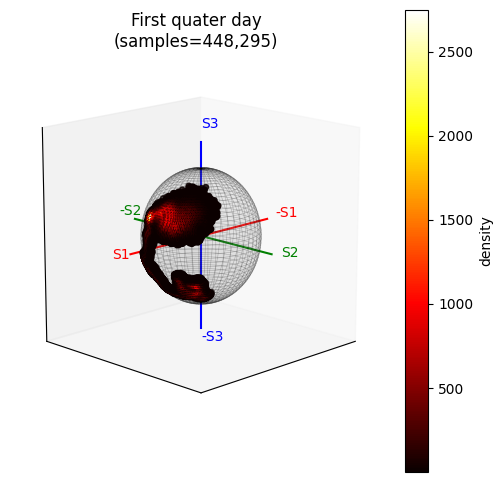

In [74]:
title = f'First quater day\n(samples={len(first_quater):,})'
x,y,z = convert_angel(first_quater[columns[9]].values, first_quater[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

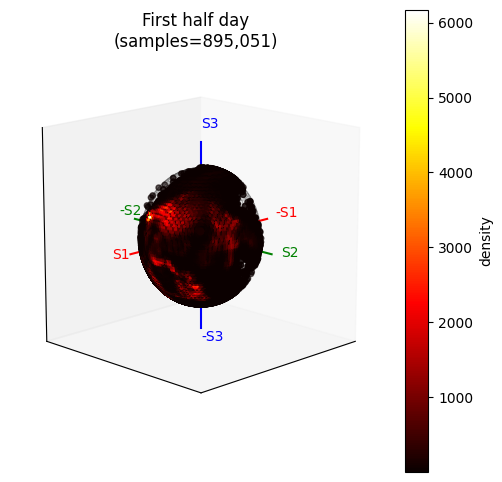

In [75]:
first_half = angle.loc[(angle.index >= start_time) & (angle.index < end_time_half)]

title = f'First half day\n(samples={len(first_half):,})'
x,y,z = convert_angel(first_half[columns[9]].values, first_half[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

In [76]:
angle_seconds_resample = angle.resample('s').mean().ffill()

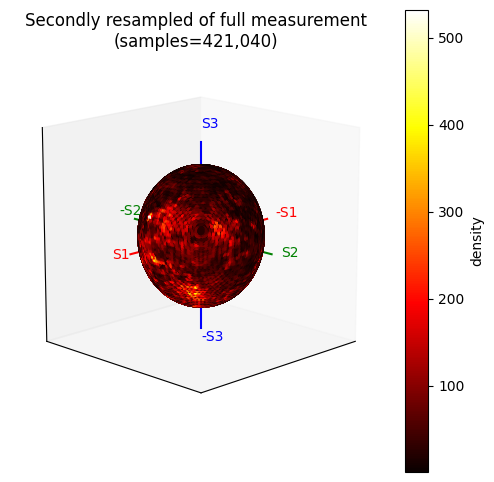

In [77]:
title= f'Secondly resampled of full measurement\n(samples={len(angle_seconds_resample):,})'

x,y,z = convert_angel(angle_seconds_resample[columns[9]].values, angle_seconds_resample[columns[10]].values)
freq = calculate_freq(x, y, z)
plot_poincare(x, y, z, freq, title=title)

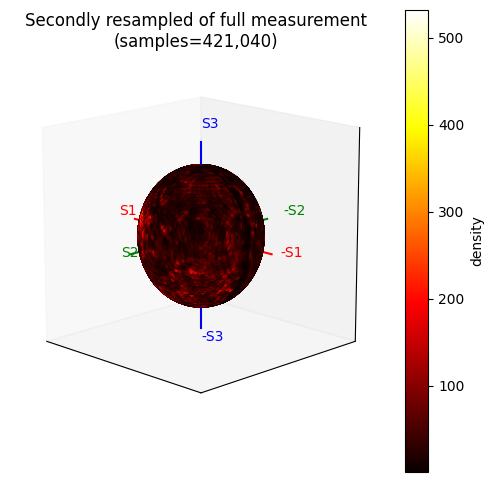

In [78]:
#elev=15, azim=45+90
title= f'Secondly resampled of full measurement\n(samples={len(angle_seconds_resample):,})'
plot_poincare(x, y, z, freq, elev=15, azim=135, title=title)

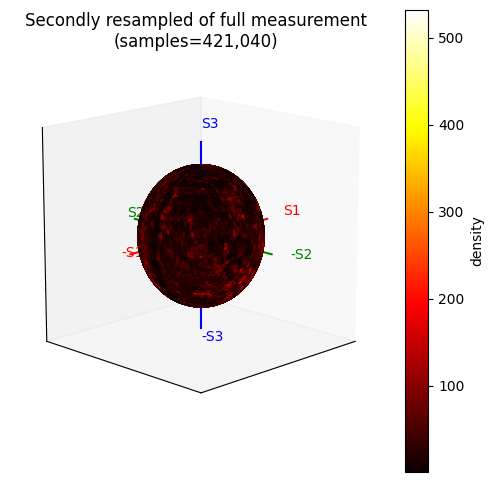

In [79]:
#elev=15, azim=45+180
title= f'Secondly resampled of full measurement\n(samples={len(angle_seconds_resample):,})'
plot_poincare(x, y, z, freq, elev=15, azim=225, title=title)

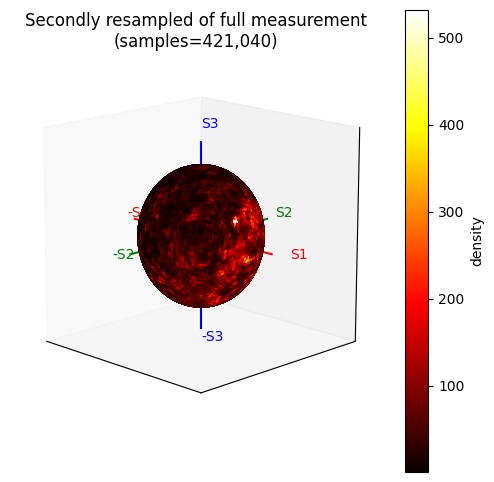

In [80]:
#elev=15, azim=45+270
title= f'Secondly resampled of full measurement\n(samples={len(angle_seconds_resample):,})'
plot_poincare(x, y, z, freq, elev=15, azim=315, title=title)